In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os, zipfile, requests, re, shap, io 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
    
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import geopandas as gpd

import joblib

from adjustText import adjust_text

In [2]:
################################################
# USDA DATASETS (FOOD ENVIRONMENT ATLAS, COUNTY POVERTY, SNAP MONTHLY)
################################################

# Function to download files from provided URLs when it doesn't exist already
def download_file(url, folder, fname):
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, fname)
    if not os.path.exists(path):
        print(f"⬇️ Downloading {fname} …")
        r = requests.get(url)
        r.raise_for_status()
        with open(path, "wb") as f:
            f.write(r.content)
    return path

# URLs for datasets 
urls = {
    "food_env": (
        "https://ers.usda.gov/sites/default/files/_laserfiche/DataFiles/113063/2025-food-environment-atlas-data.xlsx?v=30859",
        "food_env.xlsx"
    ),
    "county": (
        "https://ers.usda.gov/sites/default/files/_laserfiche/DataFiles/48747/Poverty2023.xlsx?v=22412",
        "county_poverty_2023.xlsx"
    ),
    "snap": (
        "https://www.fns.usda.gov/sites/default/files/resource-files/snap-zip-fns388a-7.zip",
        "snap_data.zip"
    )
}

# Call functions to download files from URLs
food_path   = download_file(urls["food_env"][0], "data/raw", urls["food_env"][1])
county_path = download_file(urls["county"][0],   "data/raw", urls["county"][1])
snap_path   = download_file(urls["snap"][0],     "data/raw", urls["snap"][1])

################################################
# FOOD ENVIRONMENT ATLAS – SNAP 2023
################################################

# Reviewing files and extracting records to download
food_xls = pd.ExcelFile(food_path)
food_df_list = []

# Variable mapping of descriptions
try:
    var_list_df = pd.read_excel(food_xls, sheet_name=' Variable List', header=1, dtype=str)
    food_var_map = dict(zip(var_list_df['Variable Code'], var_list_df['Variable Name']))
except Exception:
    food_var_map = {}

# Returns all columns related to snap for 2023 from food environment atlas data
for sheet in food_xls.sheet_names:
    if sheet.strip().lower() == 'variable list':
        continue
    try:
        df_raw = pd.read_excel(food_xls, sheet_name=sheet, header=None, dtype=str)
    except Exception:
        continue

    # Finds header row to search for SNAP 2023 variables
    header_row = None
    for i in range(min(10, df_raw.shape[0])):
        row_vals = df_raw.iloc[i].astype(str)
        if any(('SNAP' in v.upper() and '23' in v) for v in row_vals):
            header_row = i
            break
    if header_row is None:
        continue

    df_raw.columns = df_raw.iloc[header_row]
    df = df_raw[(header_row + 1):].copy()

    # Finds FIPS column to identify county data
    fips_candidates = [c for c in df.columns if 'FIPS' in str(c)]
    if not fips_candidates:
        continue
    df['FIPS'] = df[fips_candidates[0]].astype(str).str.zfill(5)

    # Finds all SNAP 2023 columns
    snap_cols = [c for c in df.columns if ('SNAP' in str(c).upper() and '23' in str(c))]
    if not snap_cols:
        continue

    # Converts column values to numeric
    for c in snap_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Map variable names to descriptions
    mapped_cols = [food_var_map.get(c, c) for c in snap_cols]
    df_subset = df[['FIPS'] + snap_cols].copy()
    df_subset.columns = ['FIPS'] + mapped_cols
    food_df_list.append(df_subset)

# Combines all SNAP 2023 columns and FIPS column 
if food_df_list:
    food_env_df = pd.concat(food_df_list, axis=1)
    food_env_df = food_env_df.loc[:, ~food_env_df.columns.duplicated()]

    # Average numeric columns to use as food access index
    numeric_cols = food_env_df.select_dtypes(include=[np.number]).columns
    food_env_df["food_access_index"] = food_env_df[numeric_cols].mean(axis=1, skipna=True)
    print("✅ Food Environment processed:", food_env_df.shape)
else:
    food_env_df = pd.DataFrame(columns=['FIPS', 'food_access_index'])
    print("⚠️ No SNAP-2023 variables found in Food Environment Atlas")


################################################
# COUNTY POVERTY DATA
################################################
# Reviewing files and extracting records to download
county_xls = pd.ExcelFile(county_path)
county_var_map = None

# Variable mapping of descriptions
for sheet in county_xls.sheet_names:
    if 'variable' in sheet.lower() and 'descriptions' in sheet.lower():
        var_list_df = pd.read_excel(county_xls, sheet_name=sheet, header=0, dtype=str)
        county_var_map = dict(zip(var_list_df['Column variable name'], var_list_df['Description']))
        print("✅ County variable mapping loaded:", len(county_var_map))
        break

# Returns all columns from county poverty data
county_df = None
for sheet in county_xls.sheet_names:
    df_raw = pd.read_excel(county_xls, sheet_name=sheet, header=None, dtype=str)
    header_row = None
    # Finds FIPS_Code column to identify county data
    for i in range(min(10, df_raw.shape[0])):
        if any('FIPS_Code' in str(v) for v in df_raw.iloc[i]):
            header_row = i
            break
    if header_row is None:
        continue
    df_raw.columns = df_raw.iloc[header_row]
    df = df_raw[(header_row + 1):].copy()
    if 'FIPS_Code' not in df.columns:
        continue
    df['FIPS'] = df['FIPS_Code'].astype(str).str.zfill(5)
    value_cols = [c for c in df.columns if c not in ['FIPS_Code', 'FIPS']]
    mapped_cols = [county_var_map.get(c, c) for c in value_cols] if county_var_map else value_cols
    df_subset = df[['FIPS'] + value_cols].copy()
    df_subset.columns = ['FIPS'] + mapped_cols
    county_df = df_subset
    break

if county_df is None:
    raise ValueError("❌ No FIPS column found in county poverty data!")
else:
    print("✅ County poverty data processed:", county_df.shape)


################################################
# SNAP MONTHLY DATA
################################################
# Reviewing files and unzipping files to download
snap_dfs = []
# File names are in format similar to JAN 2024
with zipfile.ZipFile(snap_path, 'r') as z:
    for fname in z.namelist():
        if not fname.lower().endswith(('.xls', '.xlsx')):
            continue
        m = re.search(r'([A-Za-z]{3})\s+(\d{4})', os.path.basename(fname))
        if not m:
            continue
        month_str, year_str = m.groups()
        try:
            month = pd.to_datetime(month_str, format='%b').month
        except:
            month = pd.to_datetime(month_str, format='%B').month
        year = int(year_str)

        try:
            df_snap_raw = pd.read_excel(z.open(fname), header=None, dtype=str)
        except Exception:
            continue

        # Finds header row to locate SNAP participants by county
        header_row = None
        for i in range(min(10, df_snap_raw.shape[0])):
            if any('SNAP All Persons Public Assistance Participation' in str(v) for v in df_snap_raw.iloc[i]):
                header_row = i
                break
        if header_row is None:
            continue

        df_snap_raw.columns = df_snap_raw.iloc[header_row]
        df_snap = df_snap_raw[(header_row + 1):].copy()
        fips_candidates = [c for c in df_snap.columns if 'Substate' in str(c) or 'Region' in str(c)]
        if not fips_candidates:
            continue

        df_snap['FIPS'] = df_snap[fips_candidates[0]].astype(str).str.slice(0, 5).str.zfill(5)
        snap_cols = [c for c in df_snap.columns if 'SNAP All Persons Public Assistance Participation' in str(c)]
        if not snap_cols:
            continue

        # Formats SNAP participants to numeric values and adds date columns to dataframe 
        df_select = df_snap[['FIPS', snap_cols[0]]].copy()
        df_select.columns = ['FIPS', 'SNAP_PA']
        df_select['SNAP_PA'] = pd.to_numeric(df_select['SNAP_PA'].str.replace(',', ''), errors='coerce')
        df_select['Year'] = year
        df_select['Month'] = month
        df_select['Date'] = pd.to_datetime(dict(year=df_select['Year'], month=df_select['Month'], day=1))
        snap_dfs.append(df_select[['FIPS', 'SNAP_PA', 'Date']])

snap_df_full = pd.concat(snap_dfs, axis=0)
snap_df_full = snap_df_full.dropna(subset=['FIPS', 'SNAP_PA'])
snap_df_full = snap_df_full.sort_values(['FIPS', 'Date']).reset_index(drop=True)
print("✅ SNAP monthly data processed:", snap_df_full.shape)


⬇️ Downloading food_env.xlsx …
⬇️ Downloading county_poverty_2023.xlsx …
⬇️ Downloading snap_data.zip …
✅ Food Environment processed: (3147, 8)
✅ County variable mapping loaded: 36
✅ County poverty data processed: (3196, 34)
✅ SNAP monthly data processed: (199752, 3)


In [3]:
################################################
# MERGE FOOD ENVIRONMENT, COUNTY POVERTY, AND SNAP MONTHLY DATA
################################################
import pandas as pd
import numpy as np
import requests

# Checks that dataframes have been created
for df_name in ['food_env_df', 'county_df', 'snap_df_full']:
    if df_name not in globals():
        raise ValueError(f"❌ {df_name} not found. Make sure prior cells have run successfully.")

# Sets similar columns to have same names (FIPS, county_name and state_abbr)
county_df.rename(columns={'FIPS_Code': 'FIPS', 'Area name': 'county_name', 'State Abbreviation': 'state_abbr'}, inplace=True)

# Merge food environment and county poverty data on FIPS code (county)
merged_df = pd.merge(county_df, food_env_df, on='FIPS', how='outer')

# Merge selected SNAP data on FIPS code (county) and average of FIPS SNAP participants
snap_avg = snap_df_full.groupby('FIPS')['SNAP_PA'].mean().reset_index()
snap_avg.rename(columns={'SNAP_PA': 'snap_avg'}, inplace=True)
merged_df = pd.merge(merged_df, snap_avg, on='FIPS', how='left')
merged_df['snap_avg'] = merged_df['snap_avg'].fillna(0)

# Adds state's 2 digit FIPS code and updates county_names when needed
try:
    fips_txt = requests.get("https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt").text.splitlines()
    state_map = {}
    for line in fips_txt:
        parts = line.split(None, 1)
        if len(parts) == 2 and parts[0].isdigit() and len(parts[0]) == 2:
            state_map[parts[0]] = parts[1].strip()
    merged_df['state_fips'] = merged_df['FIPS'].str[:2]
    merged_df['state_name'] = merged_df['state_fips'].map(state_map)

    # Updates missing county names if needed
    merged_df['county_name'] = merged_df['county_name'].fillna('Unknown County')

except Exception as e:
    print("⚠️ Could not load FIPS reference file:", e)
    merged_df['state_fips'] = merged_df['FIPS'].str[:2]
    merged_df['state_name'] = merged_df['state_abbr']
    merged_df['county_name'] = merged_df['county_name'].fillna('Unknown County')

# Fills missing values with tthe column's median 
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Adds region column based on State's FIPS code
regions = {
    "Northeast": ["01","09","23","25","33","34","36","42","44"],
    "Midwest": ["17","18","26","27","39","55","19","20","29","31","38","46"],
    "South": ["10","11","12","13","21","22","24","28","37","40","45","47","48","51","54"],
    "West": ["02","04","05","06","08","15","16","30","32","35","41","49","53","56"]
}
def get_region(fips2):
    for r, states in regions.items():
        if fips2 in states:
            return r
    return "Other"
merged_df['region'] = merged_df['state_fips'].apply(get_region)

# Sets column order for merged_df
cols_order = ['FIPS','state_fips','state_name','region','county_name','snap_avg'] + \
             [c for c in merged_df.columns if c not in ['FIPS','state_fips','state_name','region','county_name','snap_avg']]
merged_df = merged_df[cols_order]

print("✅ Merged dataframe ready for modeling:", merged_df.shape)
# print("Columns:", merged_df.columns.tolist())

✅ Merged dataframe ready for modeling: (3208, 45)


In [4]:
# Sample percentage of data to use for training model (can change from 0.0 to 1.0)
sample_frac = 1.0  
random_seed = 42

# Prepare data
df = merged_df.copy()

# Checks to see if pulling sample of data or full merged dataframe
if sample_frac < 1.0:
    df = df.sample(frac=sample_frac, random_state=random_seed)

# Removes records of counties that are missing number of SNAP participants
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['snap_avg'])

# Sets features (X) and target (y) to use in model
y = pd.to_numeric(df['snap_avg'], errors='coerce')
X = df.drop(columns=['snap_avg', 'Date', 'FIPS'], errors='ignore')

# Defines which features are caetgorical and which are numeric
categorical_features = [c for c in X.columns if X[c].dtype == 'object' or X[c].nunique() < 25]
numeric_features = [c for c in X.columns if c not in categorical_features]

print(f"✅ Data ready: {X.shape[0]} rows, {X.shape[1]} features")

✅ Data ready: 3208 rows, 43 features


In [5]:
# Splits data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

print(f"✅ Train/Test split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")

✅ Train/Test split: 2566 train, 642 test samples


In [6]:
# Model pipeline and training

# One-hot encoding of categorical variables 
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Run the preprocessing to numeric and catergorical features 
# and execute RandomForestRegressor model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=random_seed))
])

# Trains model
model.fit(X_train, y_train)

# Target predictions
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"✅ Model trained on {X_train.shape[0]} samples.")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

✅ Model trained on 2566 samples.
R² Score: 0.652
RMSE: 3375.196
MAE: 928.235


In [7]:
################################################
# Saves model pipeline
################################################
# import joblib

# File paths
model_file = "snap_model_pipeline.pkl"

# Saves the entire pipeline (preprocessor + regressor)
joblib.dump(model, model_file)
print(f"✅ Model pipeline saved to {model_file}")

✅ Model pipeline saved to snap_model_pipeline.pkl


✅ Figure saved to figures/predicted_vs_actual_snap.png


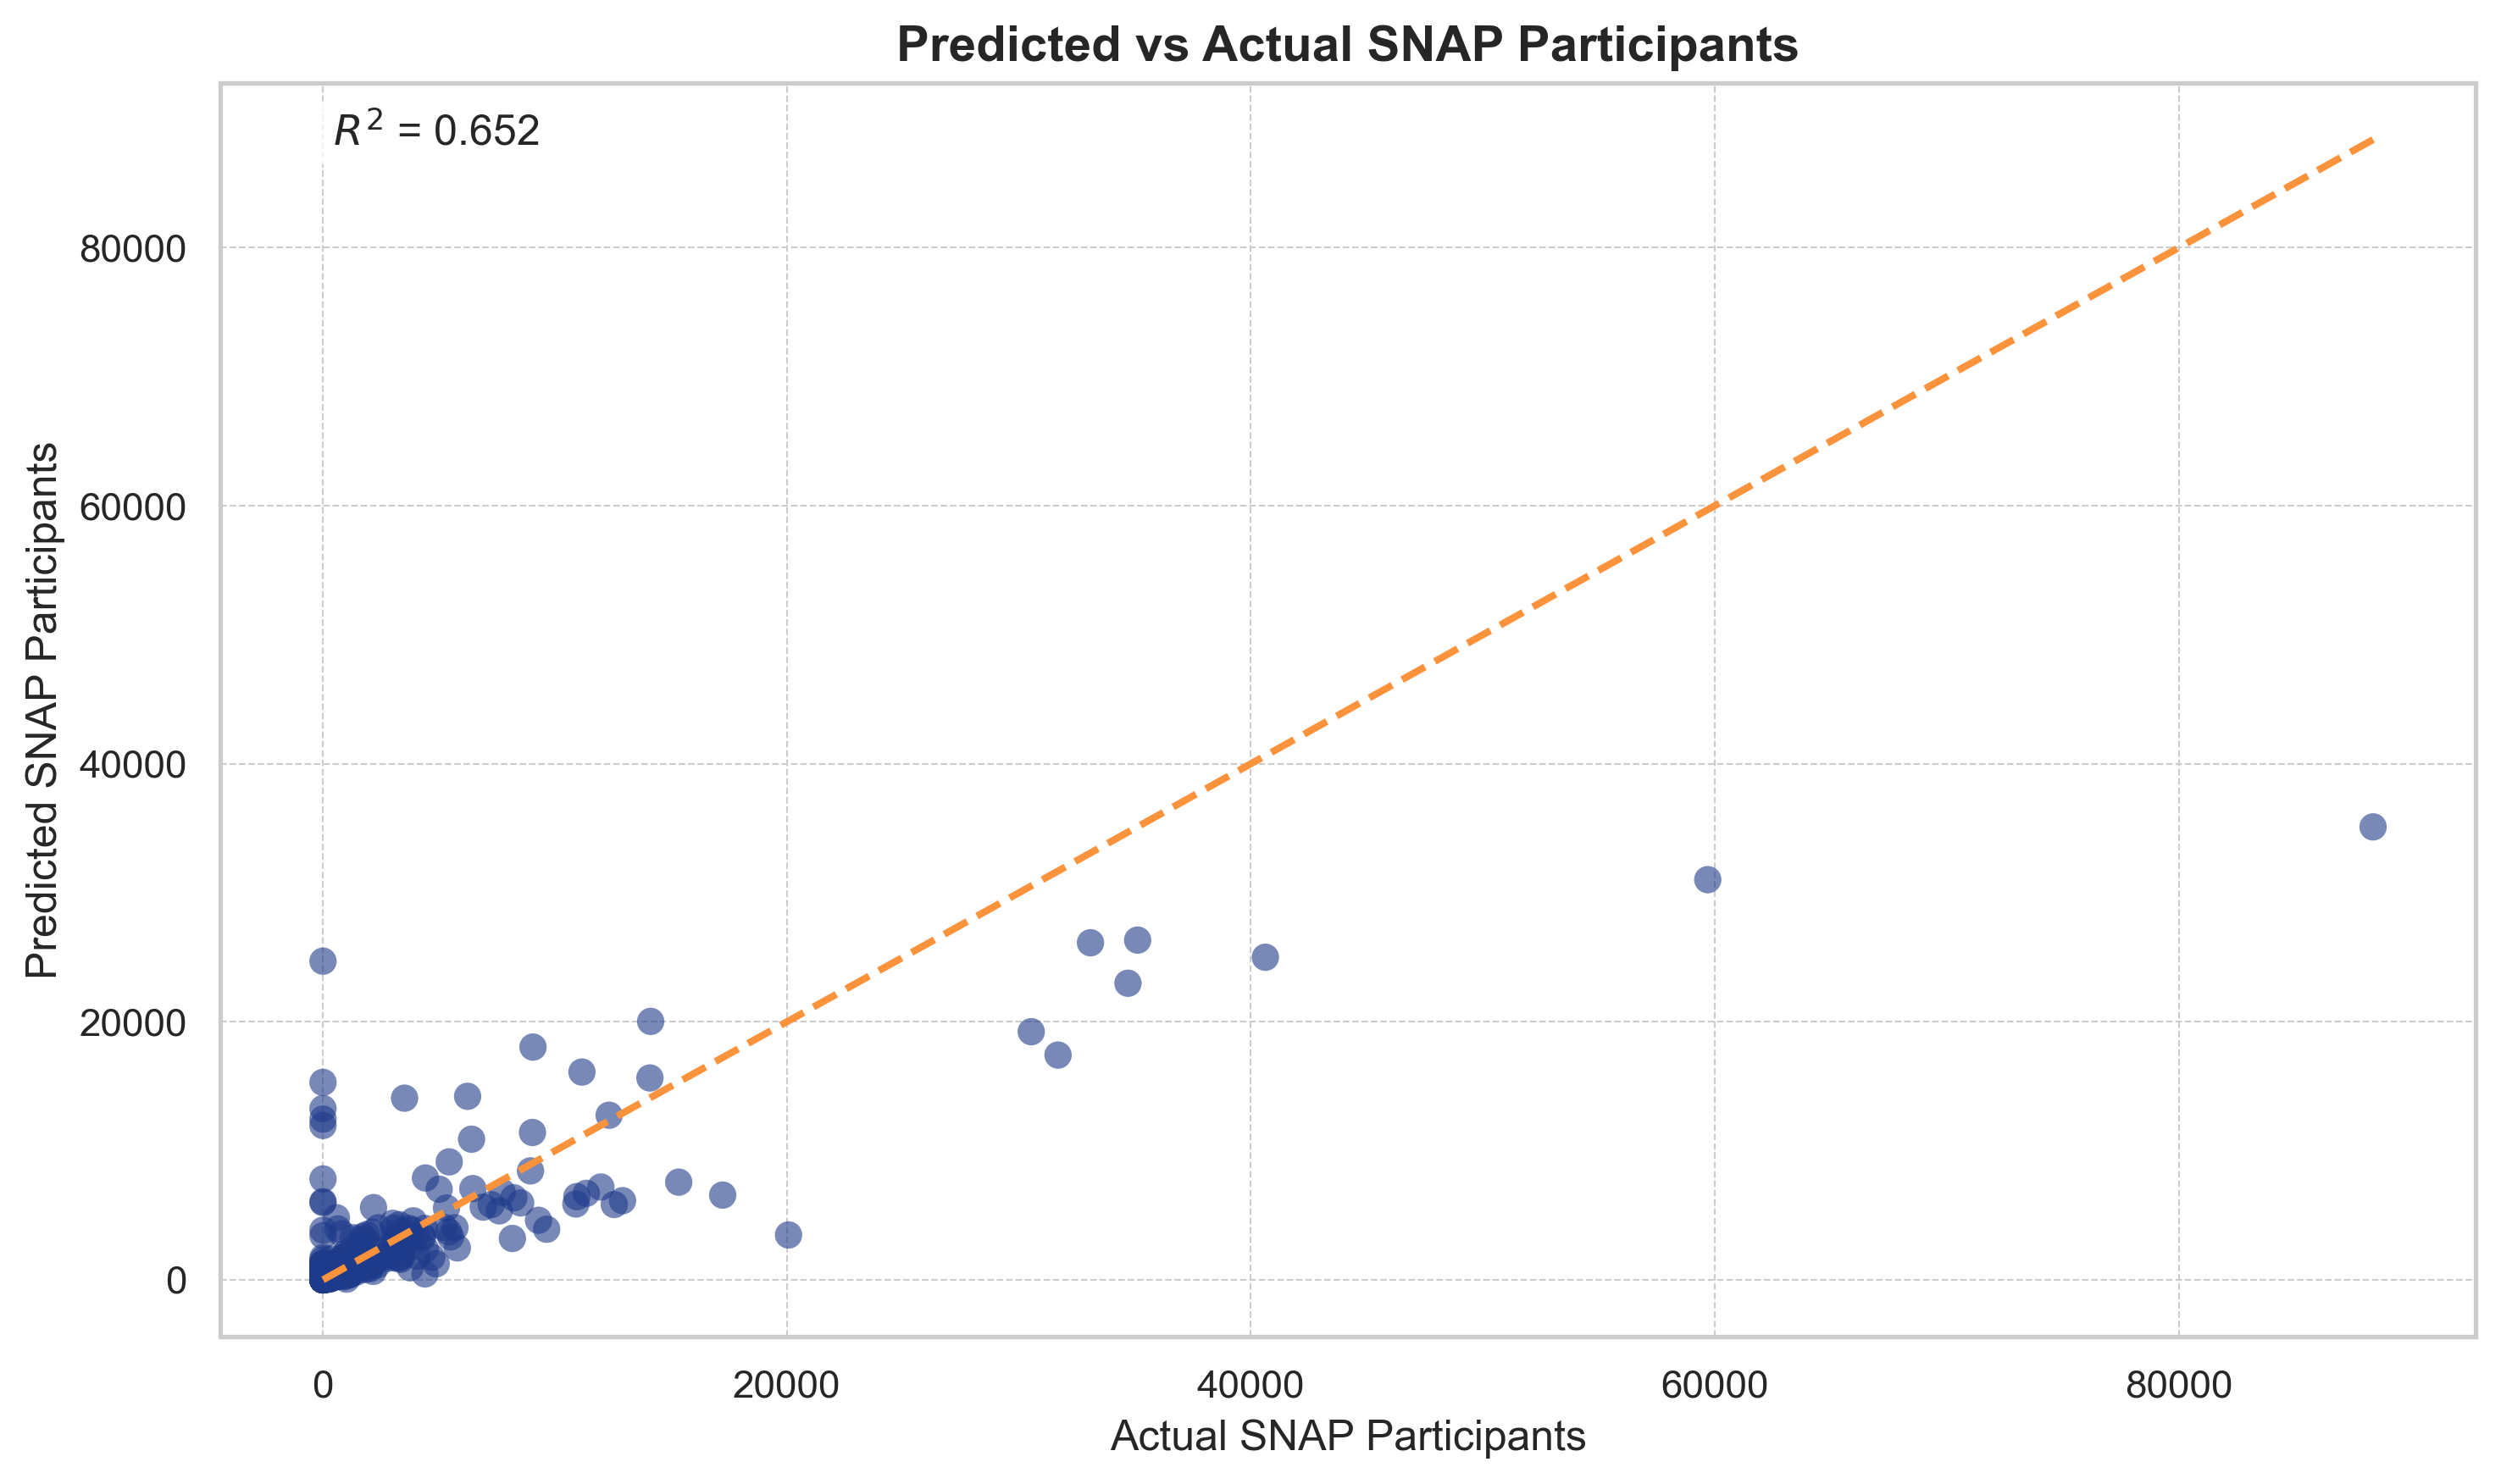

In [8]:
# Visualization - Predicted versus Actual Snap Participants

sns.set_theme(style="whitegrid")
main_color, accent_color = "#1E3A8A", "#FB923C" # deep blue, warm orange

# Plots actual values versus predicted values
plt.figure(figsize=(10, 6), dpi=300)
sns.scatterplot(x=y_test, y=y_pred, color=main_color, alpha=0.6, s=60, edgecolor="none")

# Creates orange dashed line of perfect predictions
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "--", color=accent_color, lw=2, label="Perfect Prediction")

plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}",
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.xlabel("Actual SNAP Participants")
plt.ylabel("Predicted SNAP Participants")
plt.title("Predicted vs Actual SNAP Participants", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()

# Saves chart
os.makedirs("figures", exist_ok=True)
path = "figures/predicted_vs_actual_snap.png"
plt.savefig(path, bbox_inches="tight", dpi=300)
print(f"✅ Figure saved to {path}")

# Displays chart
plt.show()


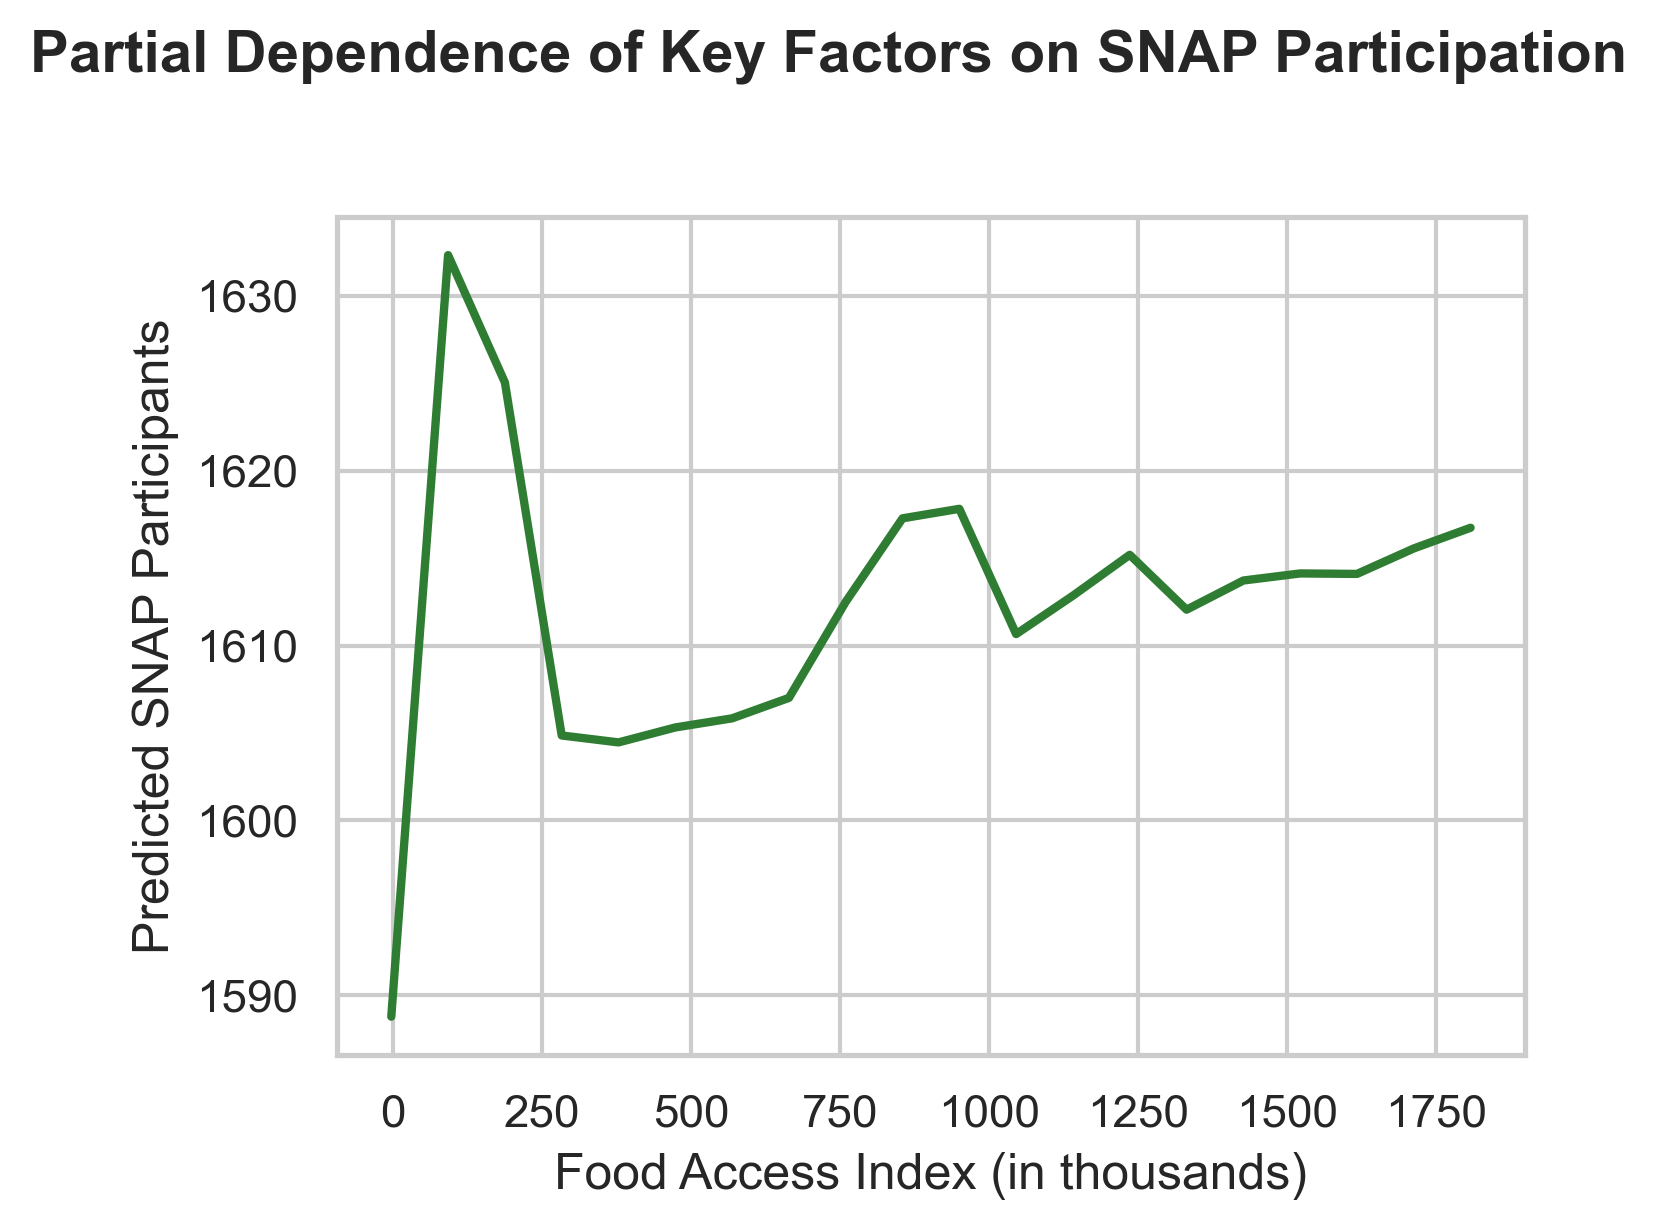

✅ Partial dependence plots saved to figures/partial_dependence_plots.png


In [9]:
################################################
# PARTIAL DEPENDENCE PLOTS
################################################
# Visualization - Influence of food_access_index on prediction with all other features remaining constant

sns.set_theme(style="whitegrid")
main_color = "#2E7D32" # deep green

# Selected important features to possibly plot
important_feats = ['food_access_index', 'snap_avg', 'poverty_intensity']
preproc_feats = model.named_steps['preprocessor'].get_feature_names_out()
important_feats = [f for f in important_feats if any(f in s for s in preproc_feats)]

# Plots important features found
n = len(important_feats)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), dpi=300)
if n == 1: axes = [axes]

for i, feat in enumerate(important_feats):

    # Run partial depence to see how feature changes  
    pd_result = partial_dependence(
        model, X_test, features=[feat], grid_resolution=20
    )

    xs = pd_result['grid_values'][0]
    ys = pd_result['average'][0]

    axes[i].xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1000:.0f}"))

    # Plots partial dependence averaged
    axes[i].plot(xs, ys, color=main_color, linewidth=2)

    axes[i].set_xlabel(feat.replace("_", " ").title() + " (in thousands)")

    axes[i].set_ylabel("Predicted SNAP Participants")

    axes[i].relim()
    axes[i].autoscale_view()
    
plt.suptitle("Partial Dependence of Key Factors on SNAP Participation", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()

# Saves and displays chart
os.makedirs("figures", exist_ok=True)
path = "figures/partial_dependence_plots.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Partial dependence plots saved to {path}")


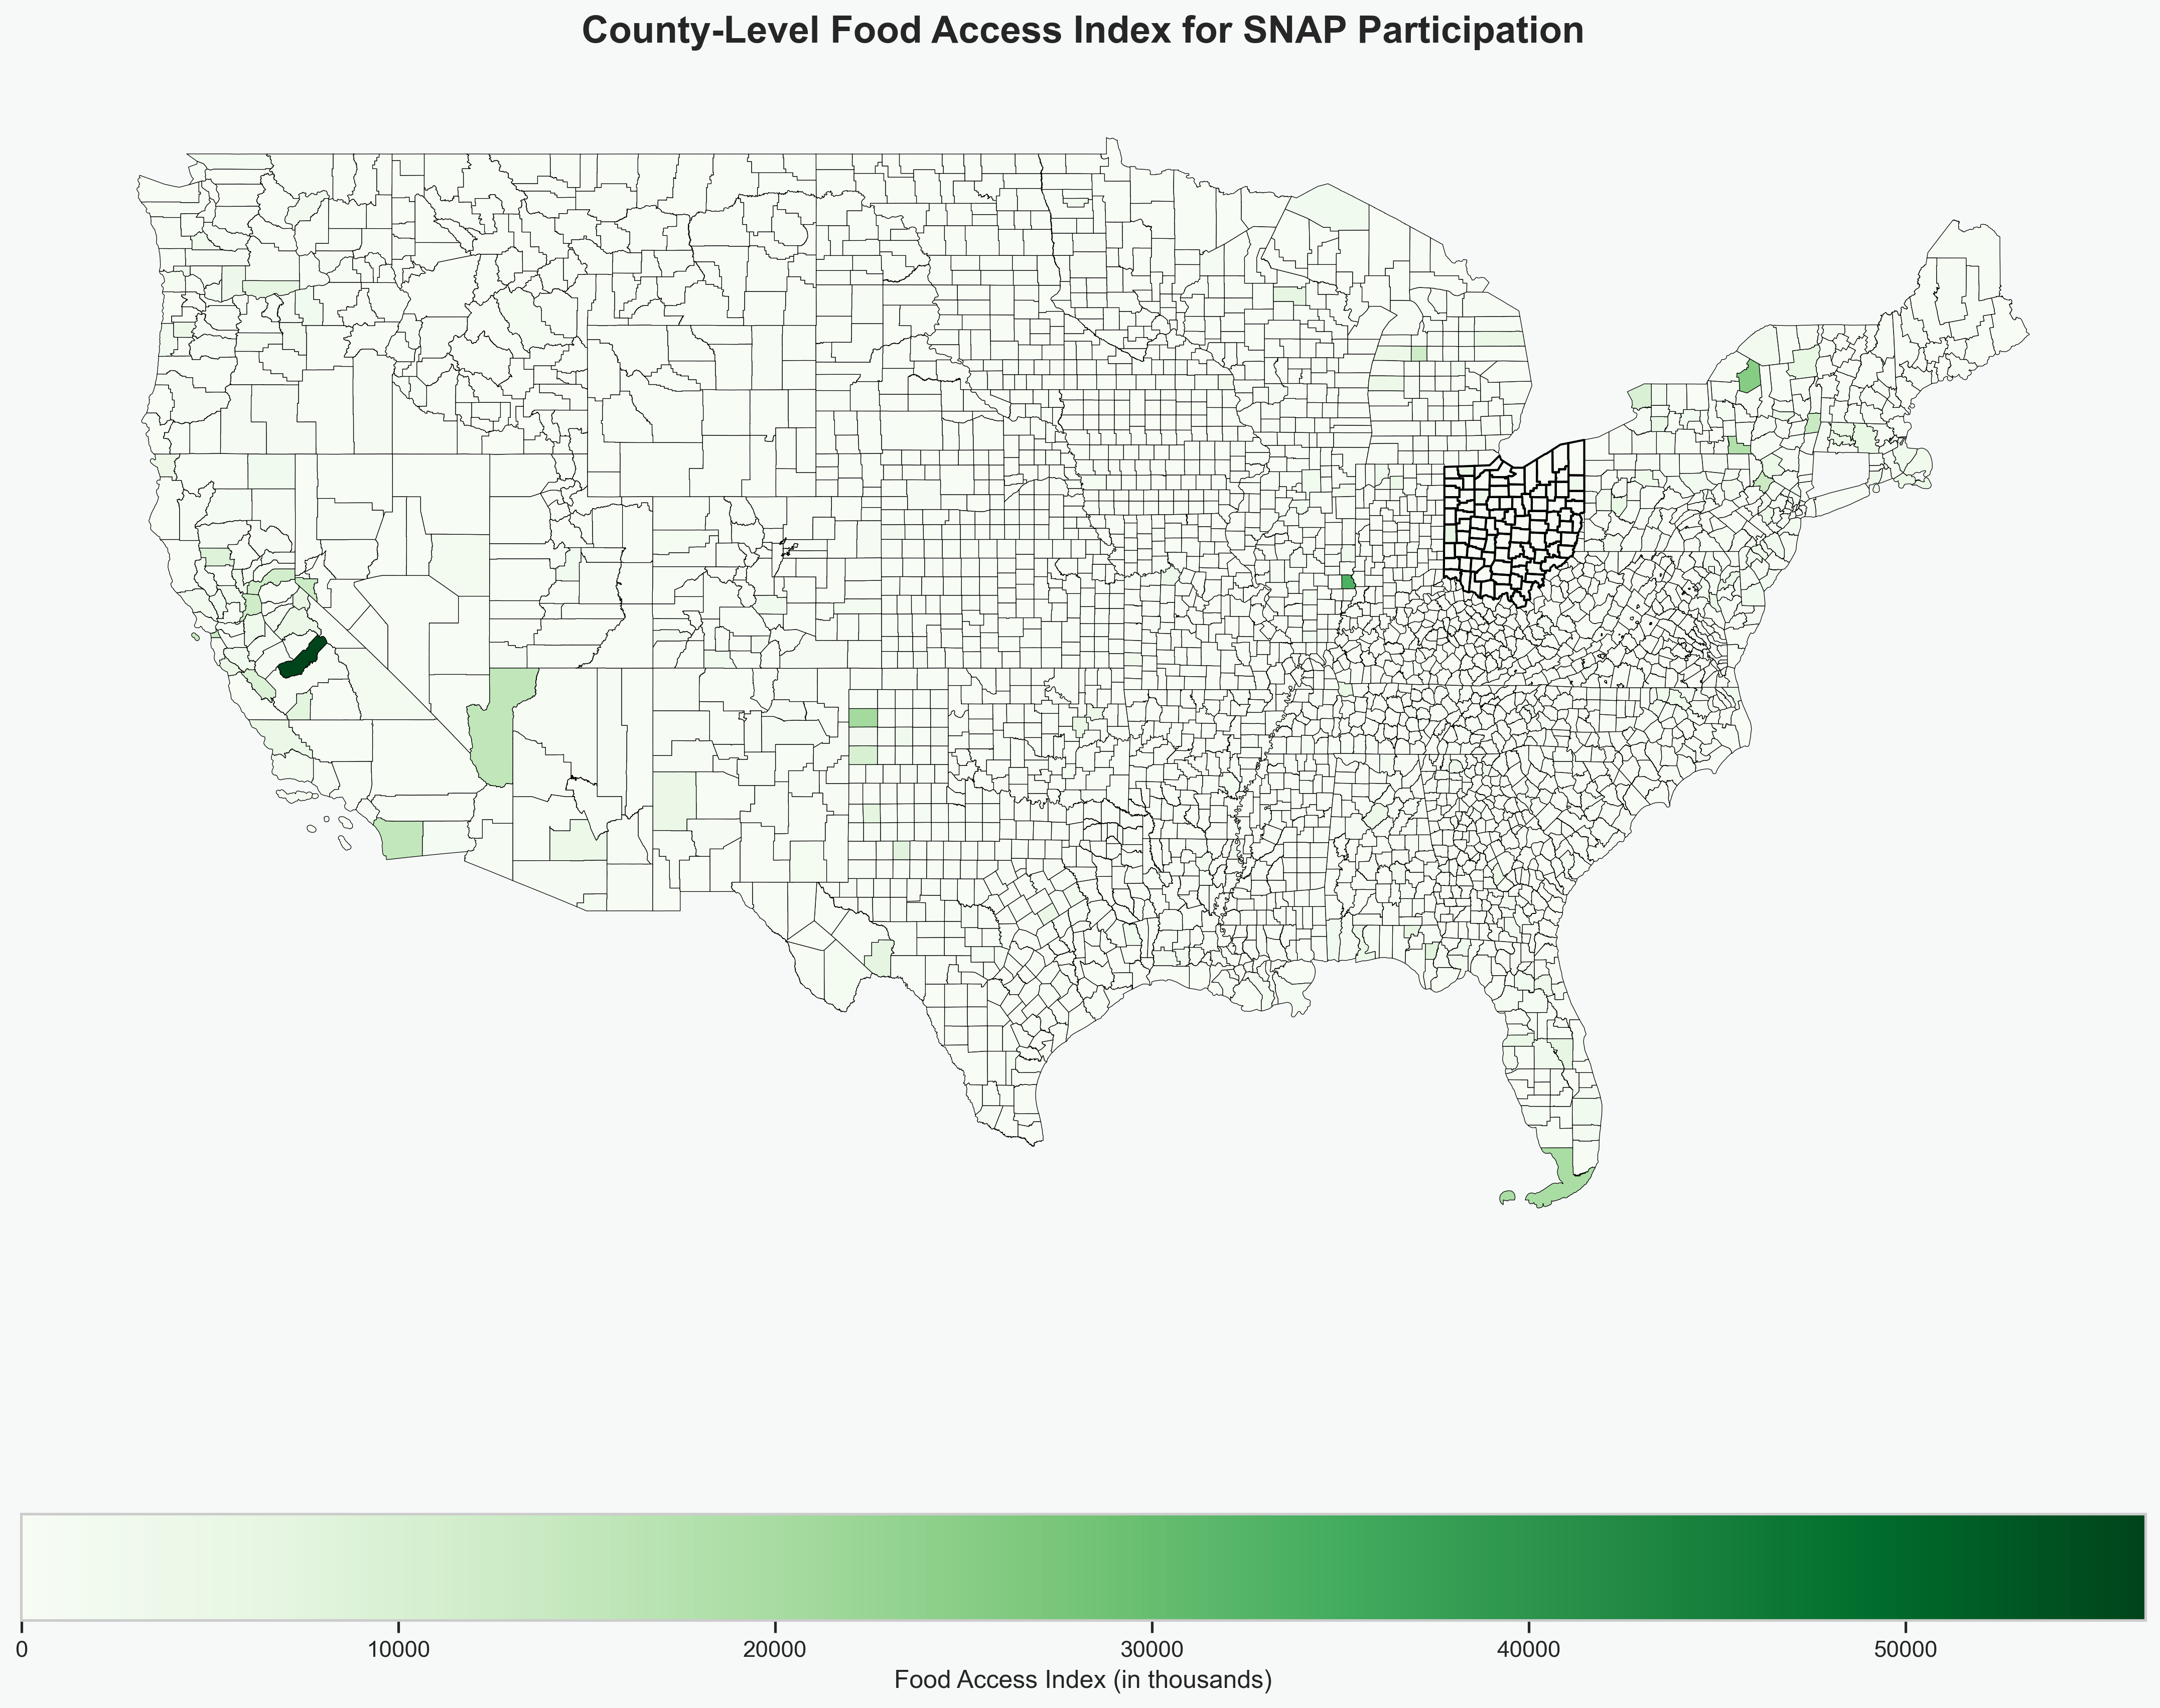

✅ County-level SNAP map saved to figures/snap_county_map.png


In [10]:
################################################
# COUNTY-LEVEL FOOD ACCESS MAP
################################################
# Visualization - Access to nutritious food by county -- darker green is better access to food
sns.set_theme(style="whitegrid")
main_color = "#2E7D32"  # deep green
bg_color = "#F7F9F9"    # light background

# Download United States map of counties
url = "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"
counties = gpd.read_file(url)

# Creates FIPS state/county FIPS code 
counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']

# Merges map data with food access index
food_env_df['FIPS'] = food_env_df['FIPS'].astype(str).str.zfill(5)
map_df = counties.merge(food_env_df[['FIPS', 'food_access_index']], on='FIPS', how='left')

# Plots counties in continental U.S. 
fig, ax = plt.subplots(figsize=(18, 12), dpi=300)
map_df = map_df[~map_df['STATEFP'].isin(['02', '15', '72'])] 

map_df.plot(
    column='food_access_index',
    cmap='Greens',
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Food Access Index (in thousands)", 'orientation': "horizontal", 'shrink': 0.8},
    ax=ax
)

# Outline state of Ohio
ohio = counties[counties["STATEFP"] == "39"]  # 39 = Ohio FIPS code
# ohio.boundary.plot(ax=ax, color=main_color, linewidth=2.5, zorder=10)  # dark green outline on top
ohio.boundary.plot(ax=ax, color="#000000", linewidth=1.0, zorder=10)  # black outline on top

# Formats legend tick marks in thousands
cbar = ax.get_figure().axes[-1]   # colorbar axis
cbar.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1000:.0f}")
)

ax.set_title("County-Level Food Access Index for SNAP Participation", fontsize=18, weight="bold", pad=20)
ax.set_axis_off()
fig.patch.set_facecolor(bg_color)
plt.tight_layout()

# Saves and displays charts
os.makedirs("figures", exist_ok=True)
path = "figures/snap_county_map.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ County-level SNAP map saved to {path}")

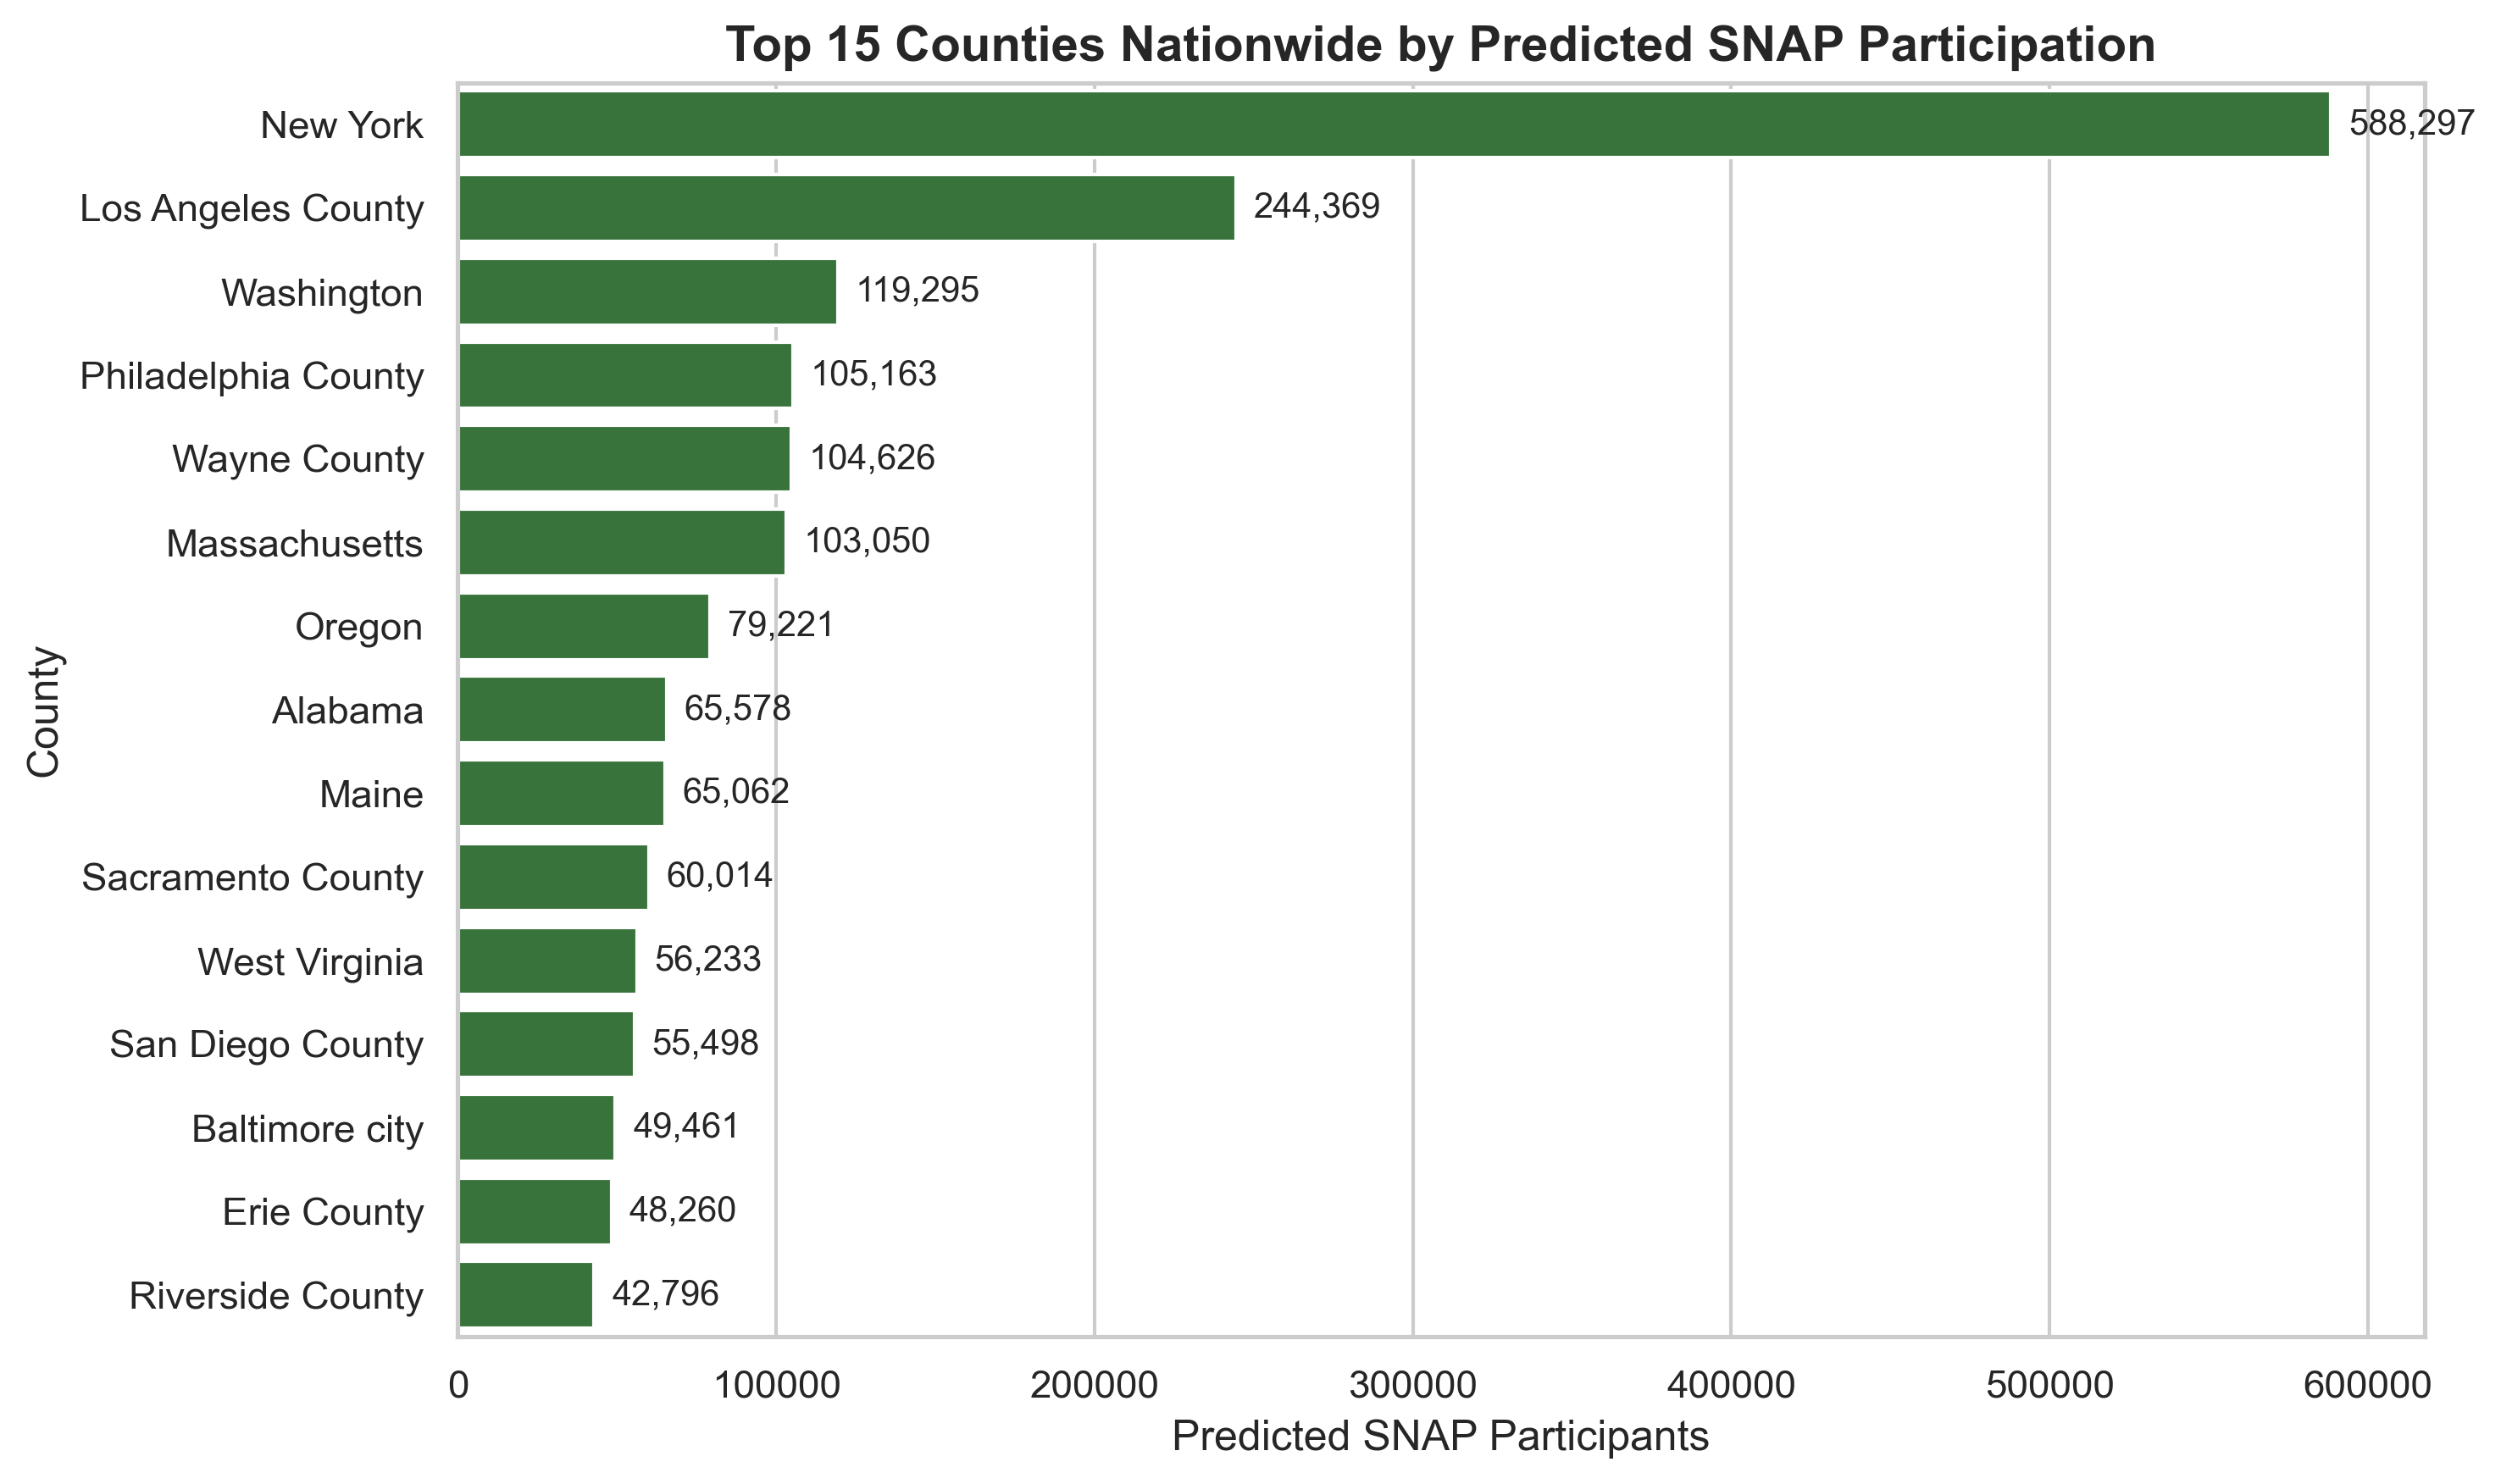

In [11]:
################################################
# Top 15 Counties Nationwide by Predicted SNAP Participation
################################################
# Visualization - Top 15 counties by predcited SNAP participants

# Get new predictions from model
merged_df["Predicted_SNAP_PA"] = model.predict(
    merged_df.drop(columns=["snap_avg", "Date"], errors="ignore")
)

# Top 15 counties  by predicted SNAP participants
top15 = merged_df.nlargest(15, "Predicted_SNAP_PA")

# Plot 
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
bars = sns.barplot(
    x="Predicted_SNAP_PA", 
    y="county_name",
    data=top15,
    color="#2E7D32",
    ax=ax
)

# If an Ohio county is listed, highlight it in red
for i, row in enumerate(top15.itertuples()):
    if row.state_name.upper() == "OHIO":
        bars.patches[i].set_facecolor("#D73027")

# Adds numeric labels to bars
for p in bars.patches:
    width = p.get_width()
    ax.annotate(f"{width:,.0f}", (width, p.get_y() + p.get_height()/2),
                xytext=(5,0), textcoords="offset points", ha='left', va='center', fontsize=10)

ax.set_title("Top 15 Counties Nationwide by Predicted SNAP Participation", fontsize=14, weight="bold")
ax.set_xlabel("Predicted SNAP Participants")
ax.set_ylabel("County")

plt.tight_layout()

# Save and display chart
plt.savefig("figures/top15_predicted_snap_highlighted.png", dpi=300, bbox_inches="tight")
plt.show()

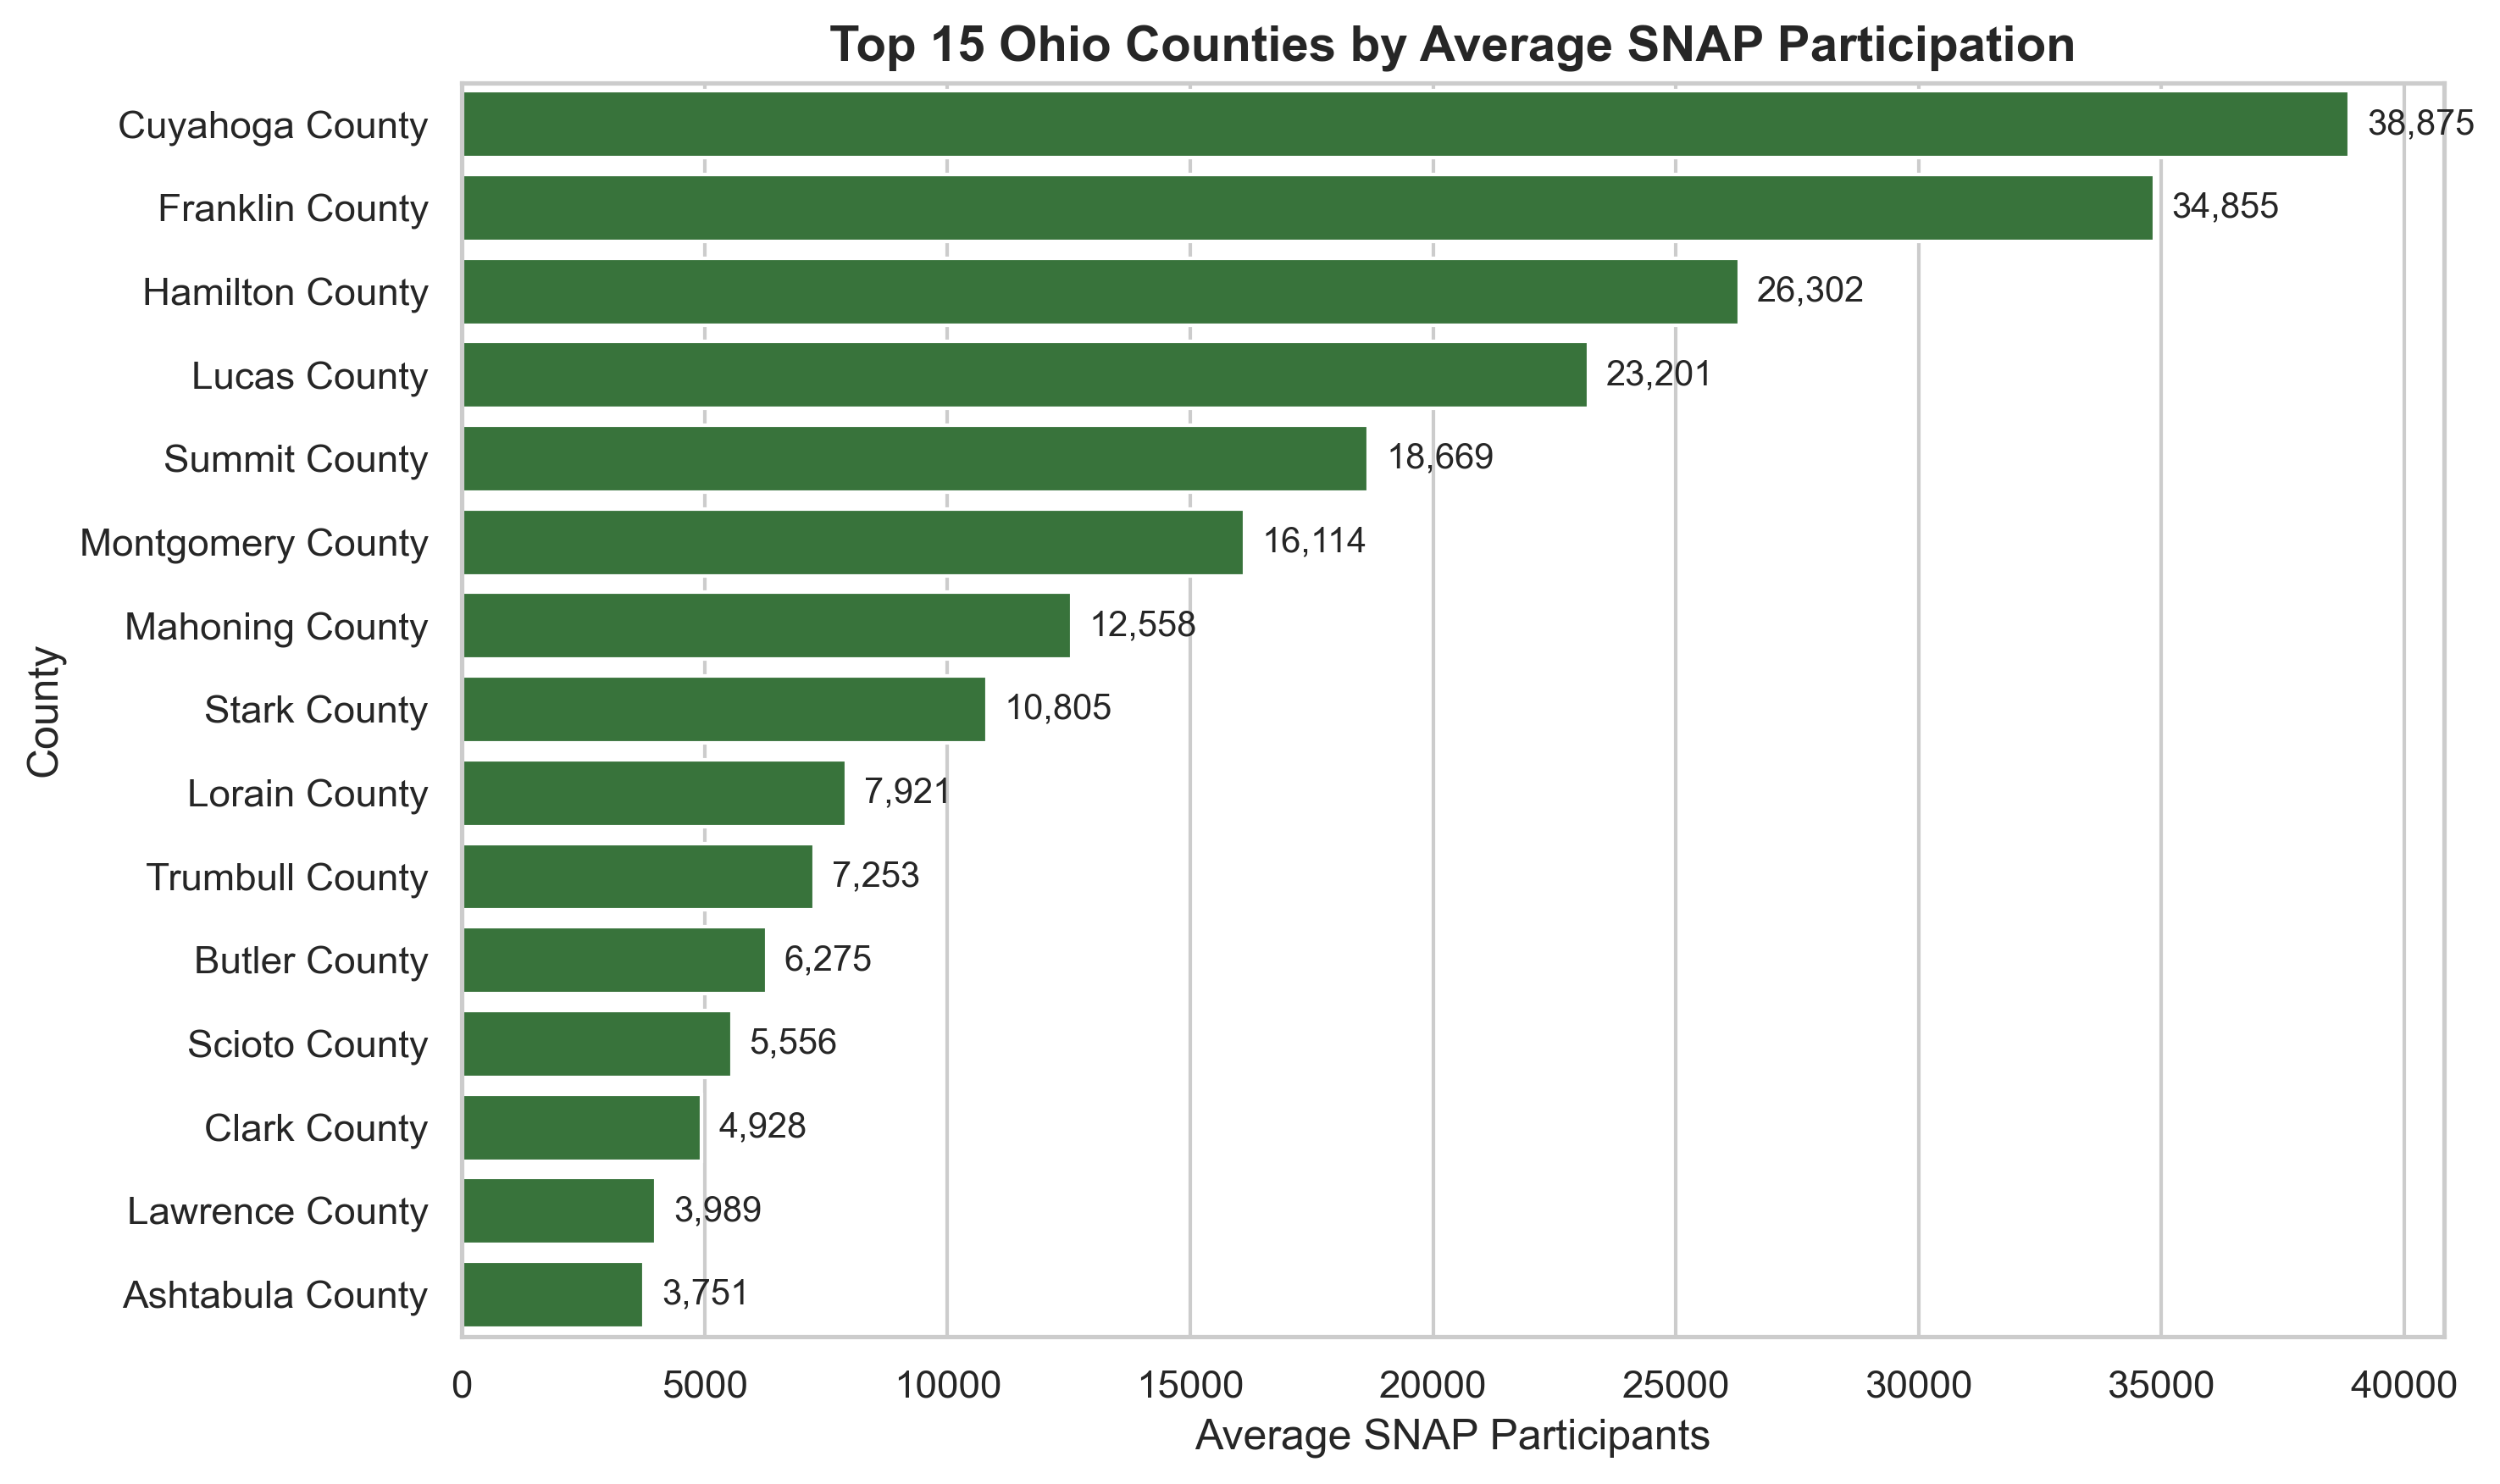

✅ Top 15 average Ohio counties plot saved to figures/top15_ohio_average_snap.png


In [12]:
################################################
# Top 15 Ohio Counties by Average SNAP Participation
################################################
# Visualization - Top 15 counties in Ohio by SNAP participants

sns.set_theme(style="whitegrid")
main_color = "#2E7D32"  # deep green

# Filter for Ohio and then top 15 counties
top_ohio = merged_df[merged_df['state_name'] == "OHIO"].nlargest(15, "snap_avg")

# Plot
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
sns.barplot(
    x="snap_avg", y="county_name", data=top_ohio,
    color=main_color, ax=ax
)

ax.set_xlabel("Average SNAP Participants")
ax.set_ylabel("County")
ax.set_title("Top 15 Ohio Counties by Average SNAP Participation", fontsize=14, weight="bold")

# Adds numeric labels to bars
for p in ax.patches:
    ax.annotate(f"{p.get_width():,.0f}",
                (p.get_width(), p.get_y() + p.get_height()/2),
                xytext=(5,0), textcoords="offset points",
                va='center', ha='left', fontsize=10)

plt.tight_layout()

# Saves and displays chart
os.makedirs("figures", exist_ok=True)
path = "figures/top15_ohio_average_snap.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Top 15 average Ohio counties plot saved to {path}")


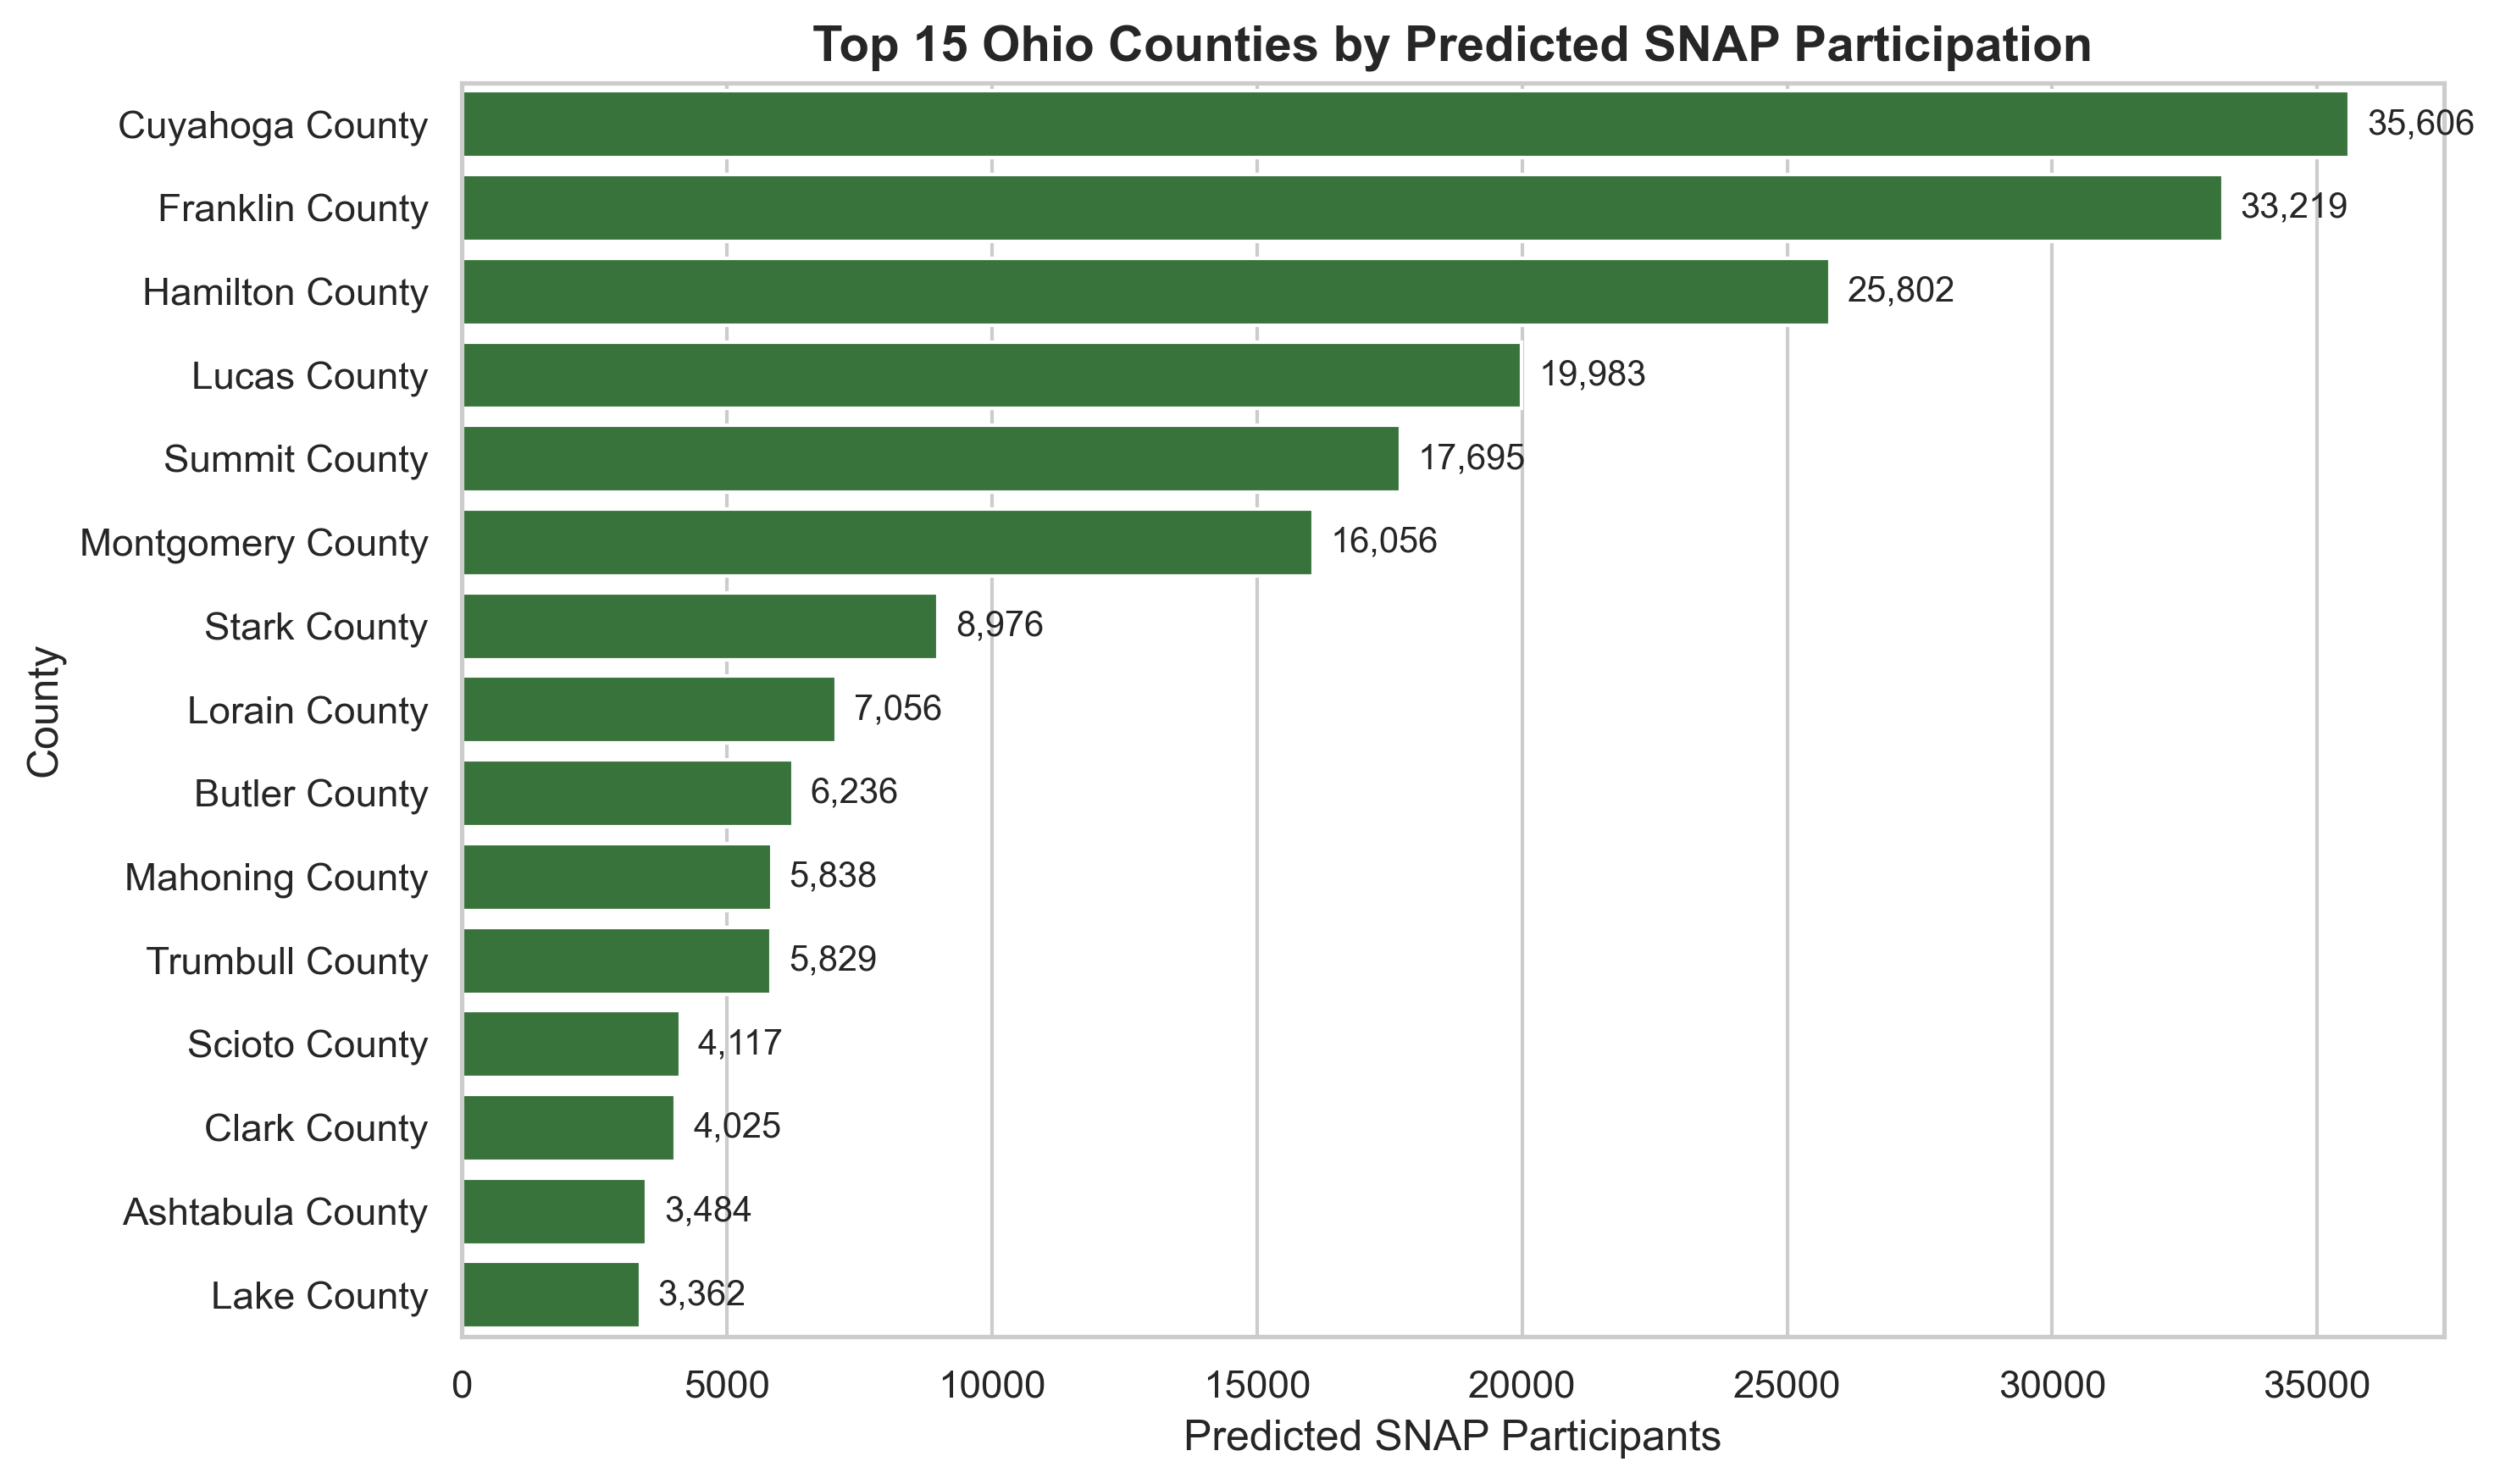

✅ Top 15 predicted Ohio counties plot saved to figures/top15_ohio_predicted_snap.png


In [13]:
################################################
# Top 15 Ohio Counties by Predicted SNAP Participation
################################################
# Visualization - Top 15 counties in Ohio by SNAP participants

sns.set_theme(style="whitegrid")
main_color = "#2E7D32"  # deep green

# Filter for Ohio and then top 15 counties
top_ohio = merged_df[merged_df['state_name'] == "OHIO"].nlargest(15, "Predicted_SNAP_PA")

# Plot
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
sns.barplot(
    x="Predicted_SNAP_PA", y="county_name", data=top_ohio,
    color=main_color, ax=ax
)

ax.set_xlabel("Predicted SNAP Participants")
ax.set_ylabel("County")
ax.set_title("Top 15 Ohio Counties by Predicted SNAP Participation", fontsize=14, weight="bold")

# Adds numeric labels to bars
for p in ax.patches:
    ax.annotate(f"{p.get_width():,.0f}",
                (p.get_width(), p.get_y() + p.get_height()/2),
                xytext=(5,0), textcoords="offset points",
                va='center', ha='left', fontsize=10)

plt.tight_layout()

# Saves and displays chart
os.makedirs("figures", exist_ok=True)
path = "figures/top15_ohio_predicted_snap.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Top 15 predicted Ohio counties plot saved to {path}")


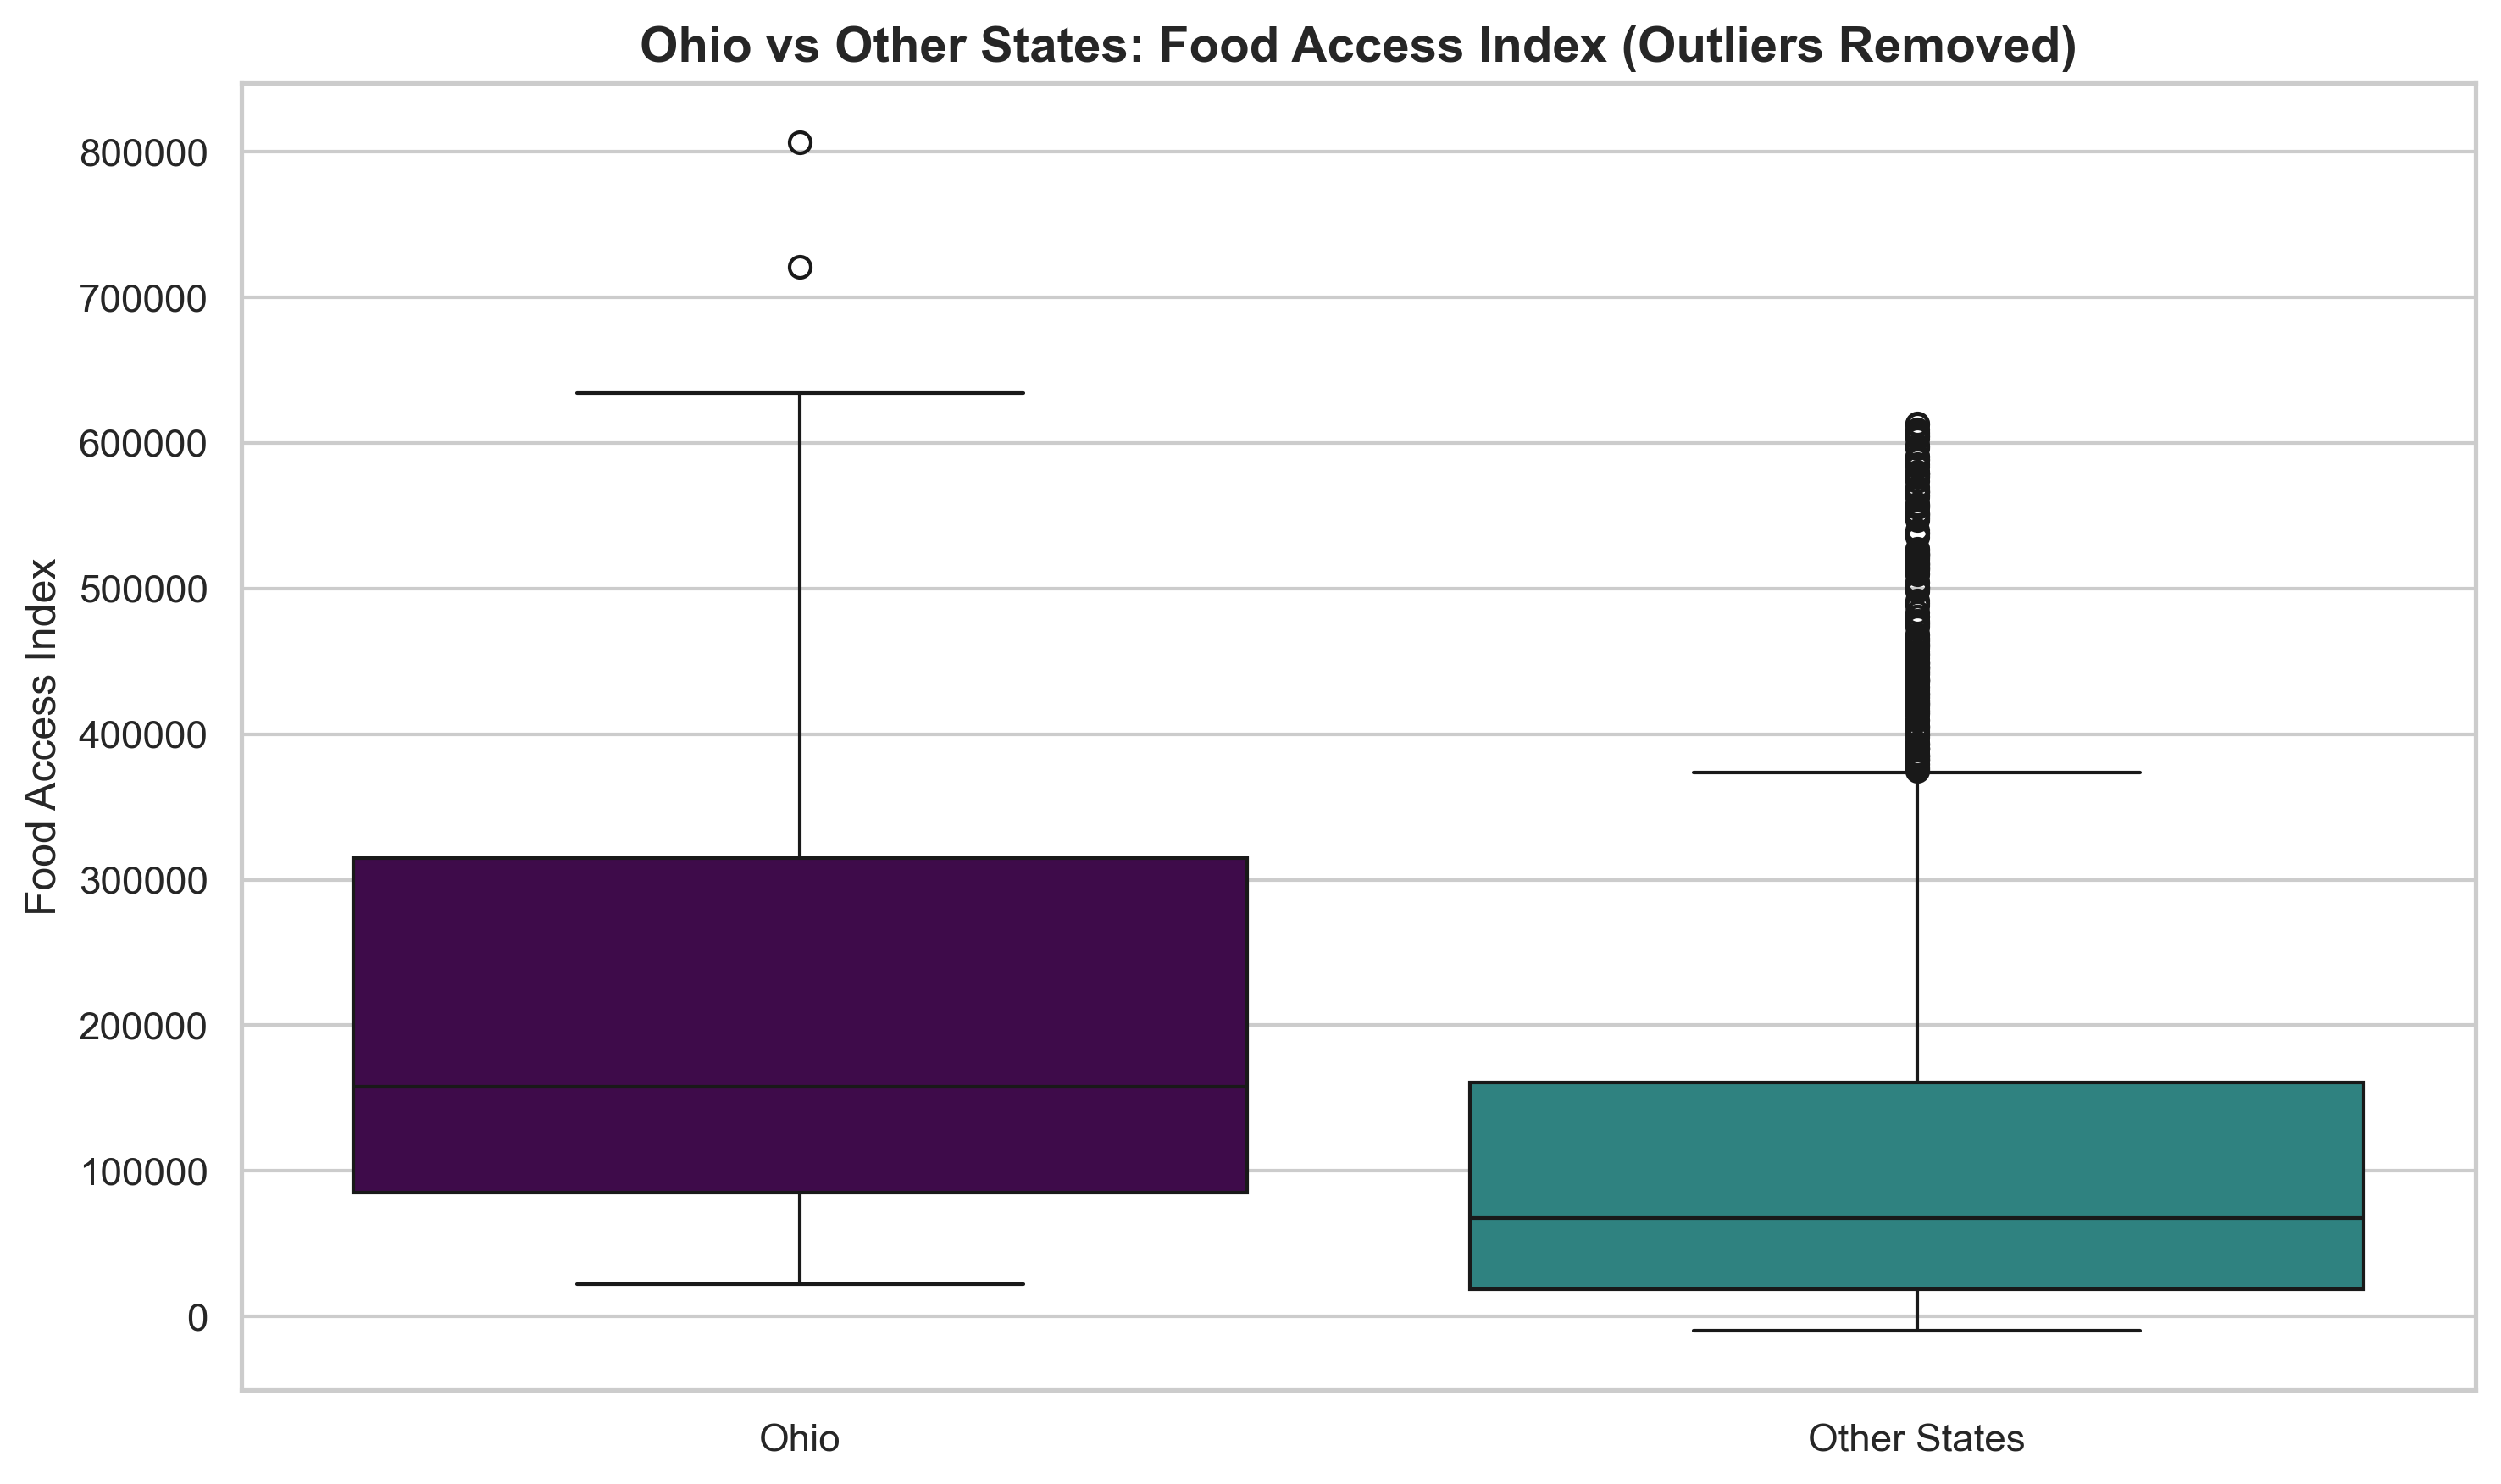

✅ Boxplot saved to figures/ohio_vs_others_food_access_filtered.png


In [14]:
# Visualization - Boxplots comparing Ohio with other states by the food access index 
# Outliers removed and Ohio has better access to food than other states


merged_df['ohio_vs_others'] = merged_df['state_name'].apply(
    lambda x: 'Ohio' if isinstance(x, str) and x.lower() == 'ohio' else 'Other States'
)

# Removed extreme outliers in each group (Ohio vs others)
filtered_df = pd.DataFrame()
for group, group_df in merged_df.groupby('ohio_vs_others'):
    Q1 = group_df['food_access_index'].quantile(0.25)
    Q3 = group_df['food_access_index'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_group = group_df[(group_df['food_access_index'] >= lower) & 
                              (group_df['food_access_index'] <= upper)]
    filtered_df = pd.concat([filtered_df, filtered_group])

# Boxplot
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
sns.boxplot(
    x="ohio_vs_others",
    y="food_access_index",
    hue="ohio_vs_others",                
    data=filtered_df,
    palette={"Ohio":"#440154", "Other States":"#21908d"}, # colors -- can change later
    ax=ax,
    dodge=False
)

# Removes legend for cleaner look
if ax.get_legend() is not None:
    ax.get_legend().remove()

ax.set_title("Ohio vs Other States: Food Access Index (Outliers Removed)", fontsize=14, weight="bold")
ax.set_ylabel("Food Access Index")
ax.set_xlabel("")

plt.tight_layout()

# Saves and displays chart
os.makedirs("figures", exist_ok=True)
path = "figures/ohio_vs_others_food_access_filtered.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Boxplot saved to {path}")

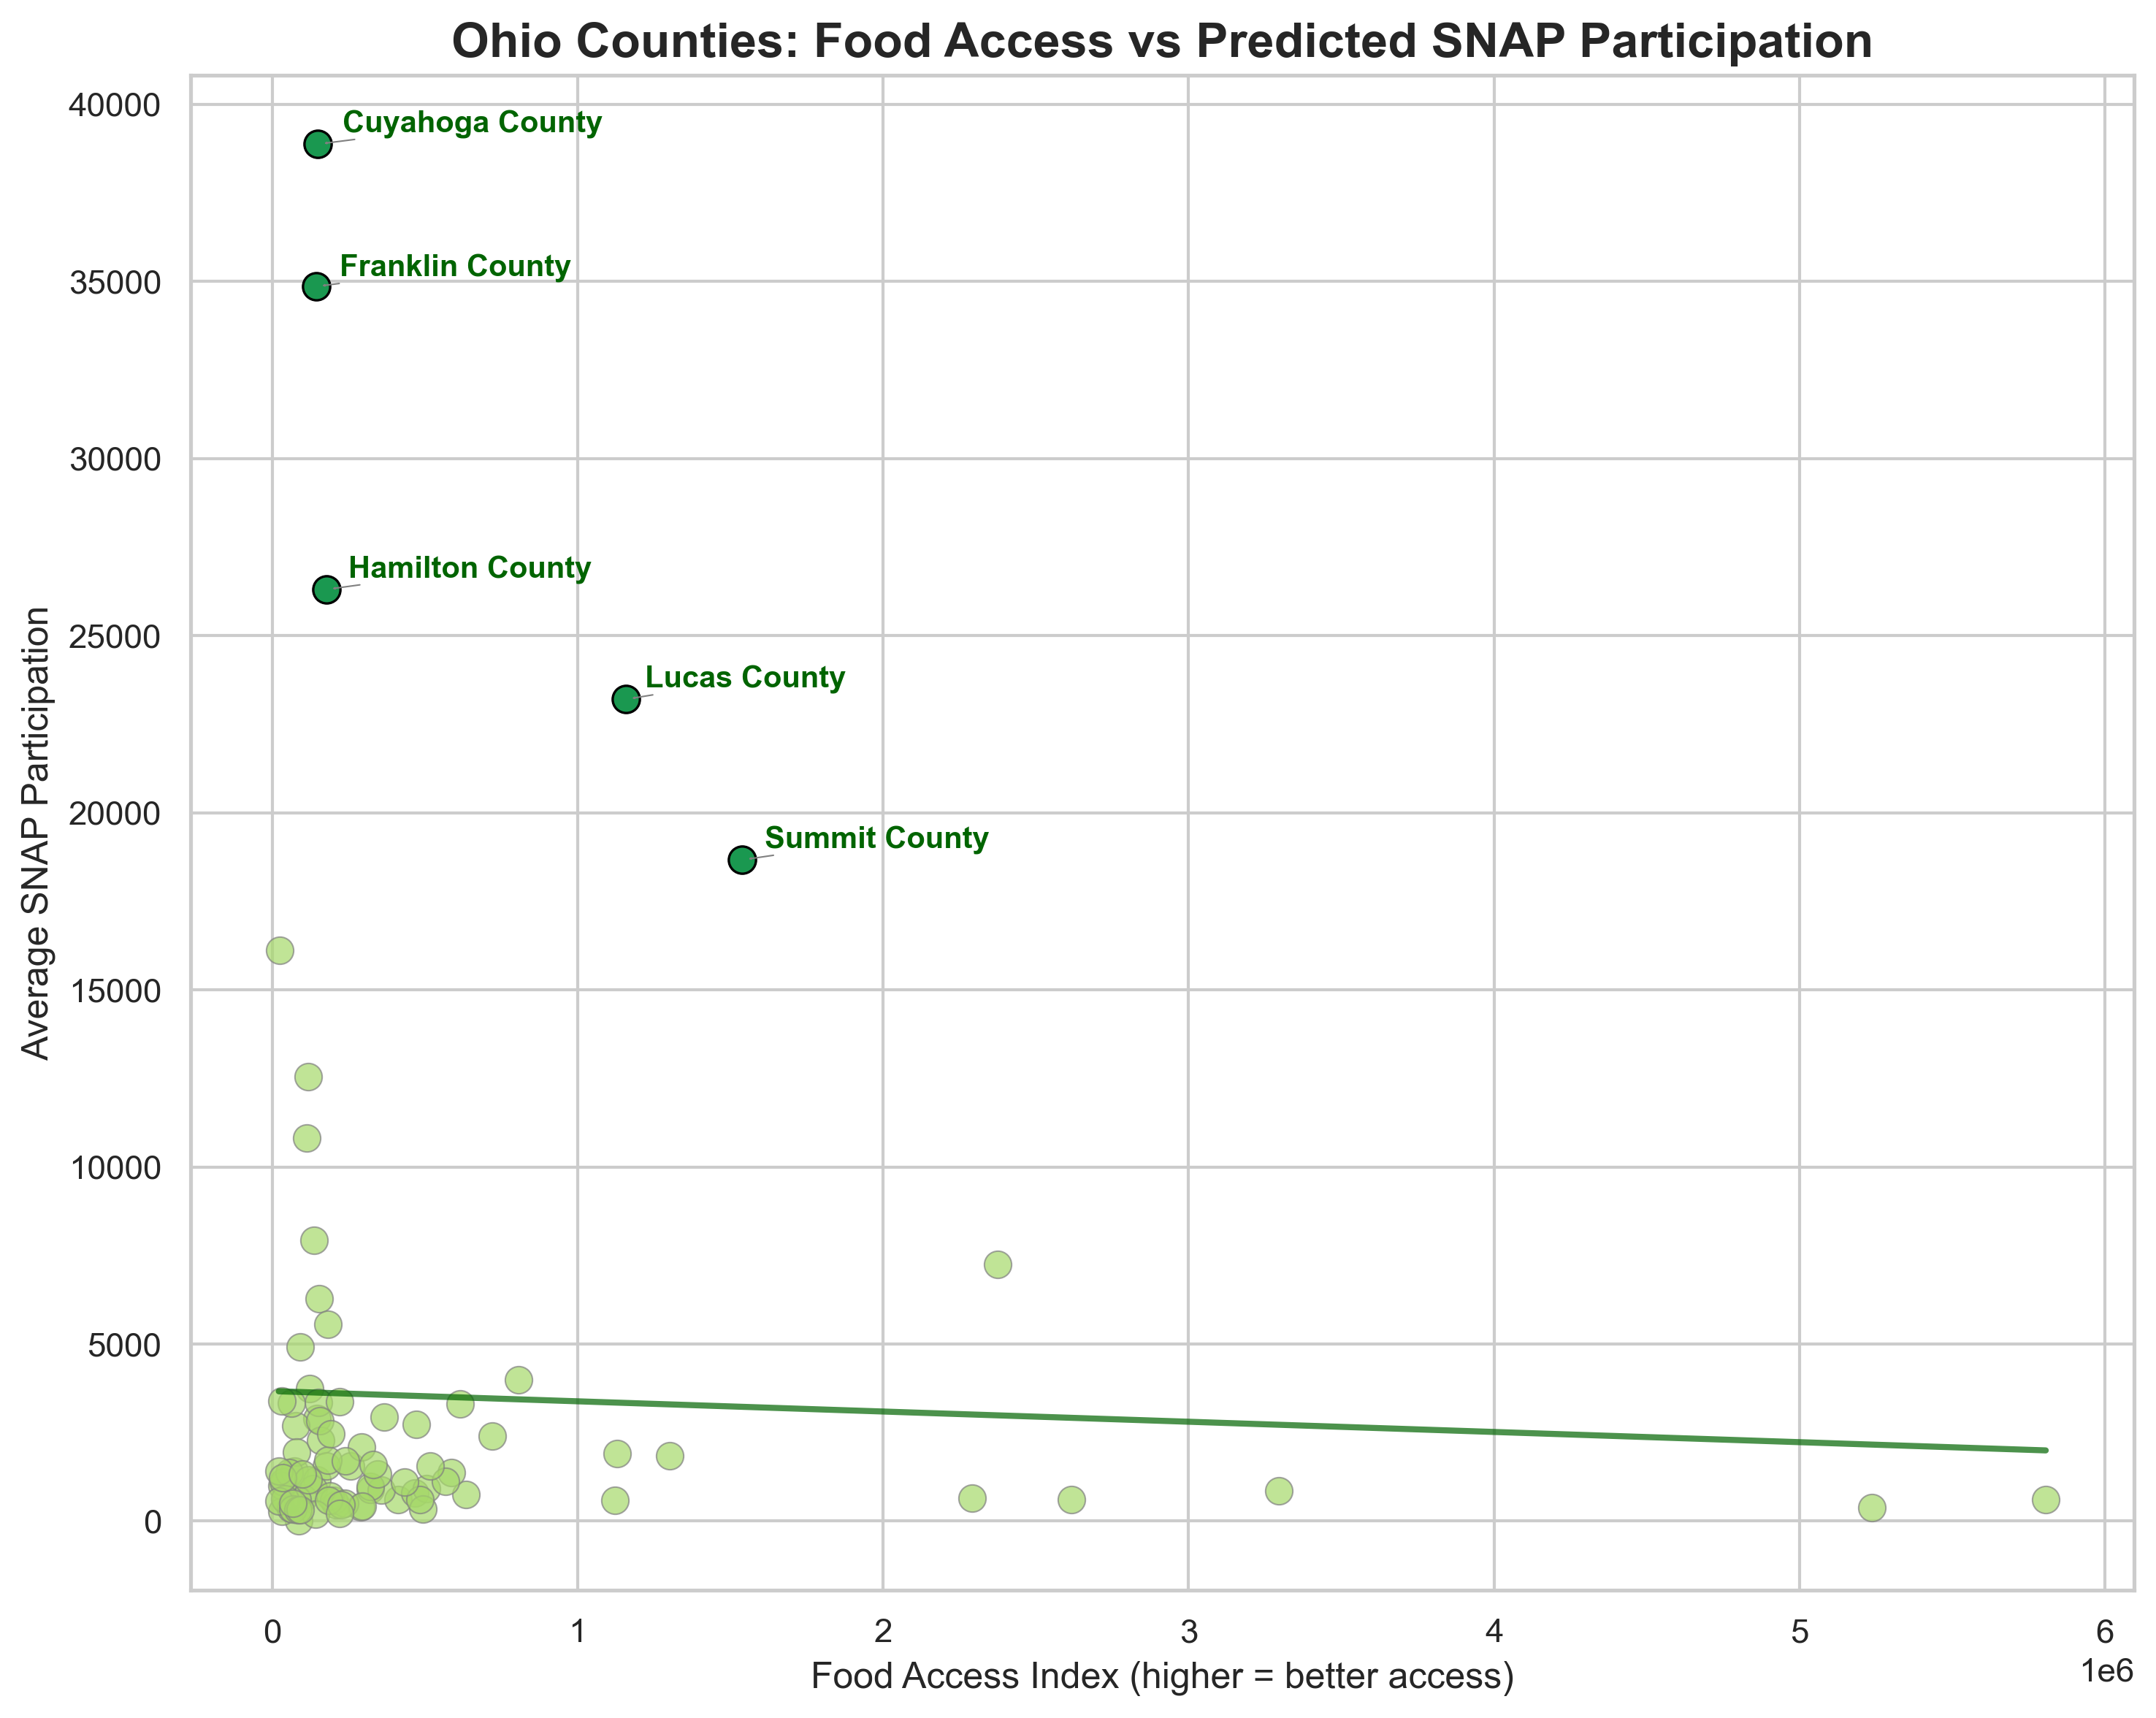

✅ Scatter plot saved to figures/ohio_food_access_vs_snap_regression_top5_highlighted.png


In [15]:
# Visualization - Scatterplot comparing Ohio counties by the food access index and SNAP participants 
# trend line shows better access to food decreases snap participants

# Filters to data for Ohio
ohio_df = merged_df[merged_df['state_name'].str.upper() == "OHIO"].copy()

# Drops records with missing values and pulls numeric values for chart
ohio_df_clean = ohio_df[['county_name', 'food_access_index', 'snap_avg']].copy()
ohio_df_clean = ohio_df_clean.dropna()
ohio_df_clean['snap_avg'] = pd.to_numeric(ohio_df_clean['snap_avg'], errors='coerce')
ohio_df_clean['food_access_index'] = pd.to_numeric(ohio_df_clean['food_access_index'], errors='coerce')
ohio_df_clean = ohio_df_clean.dropna()

#  Top 5 counties to emphasize in chart
top_points = ohio_df_clean.nlargest(5, 'snap_avg')

# Scatterplot
fig, ax = plt.subplots(figsize=(10,8), dpi=300)

sns.scatterplot(
    x="food_access_index",
    y="snap_avg",
    data=ohio_df_clean,
    color="#a6d96a",
    edgecolor="gray",
    linewidth=0.5,
    alpha=0.7,
    s=80,
    ax=ax
)

# Highlight for top 5 counties
sns.scatterplot(
    x="food_access_index",
    y="snap_avg",
    data=top_points,
    color="#1a9850",
    edgecolor="black",
    linewidth=0.8,
    s=80,
    ax=ax
)

# Trend Line without confidence interval
sns.regplot(
    x="food_access_index",
    y="snap_avg",
    data=ohio_df_clean,
    scatter=False,
    ax=ax,
    line_kws={"color": "darkgreen", "alpha": 0.7, "lw": 2},
    ci=None
)

# R-squared results displayed on chart
X = ohio_df_clean[['food_access_index']].values
y = ohio_df_clean['snap_avg'].values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

ax.text(
    0.05, 0.95, f"",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

# Show names of top 5 counties
texts = []
for _, row in top_points.iterrows():
    texts.append(ax.text(
        row['food_access_index'], row['snap_avg'], row['county_name'],
        fontsize=10, weight="bold", color="darkgreen"
    ))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


ax.set_title("Ohio Counties: Food Access vs Predicted SNAP Participation", fontsize=16, weight="bold")
ax.set_xlabel("Food Access Index (higher = better access)", fontsize=12)
ax.set_ylabel("Average SNAP Participation", fontsize=12)

plt.tight_layout()

# Saves and displays chart
os.makedirs("figures", exist_ok=True)
path = "figures/ohio_food_access_vs_snap_regression_top5_highlighted.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Scatter plot saved to {path}")

In [16]:
################################################
# Prepares data for Ohio map charts 
################################################

# URL for the US counties cartographic boundary file (20m resolution, 2022)
shp_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_20m.zip"

# Downloads and unzips shapefile to folder with same name
r = requests.get(shp_url)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("cb_2022_us_county_20m") 

# Loads shapefile
counties_gdf = gpd.read_file(os.path.join("cb_2022_us_county_20m", "cb_2022_us_county_20m.shp"))

# Keeps only Ohio (STATEFP 39)
ohio_gdf = counties_gdf[counties_gdf['STATEFP'] == '39'].copy()

# Ensures FIPS codes have leading zeros
merged_df['FIPS'] = merged_df['FIPS'].astype(str).str.zfill(5)

# Merge shapefile with Ohio data
ohio_gdf = ohio_gdf.merge(
    merged_df[['FIPS', 'snap_avg', 'food_access_index', 'county_name', 'Predicted_SNAP_PA']],
    left_on='GEOID',
    right_on='FIPS',
    how='left'
)

# print(ohio_gdf.head())


 98%|===================| 631/642 [00:22<00:00]       /opt/anaconda3/lib/python3.11/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


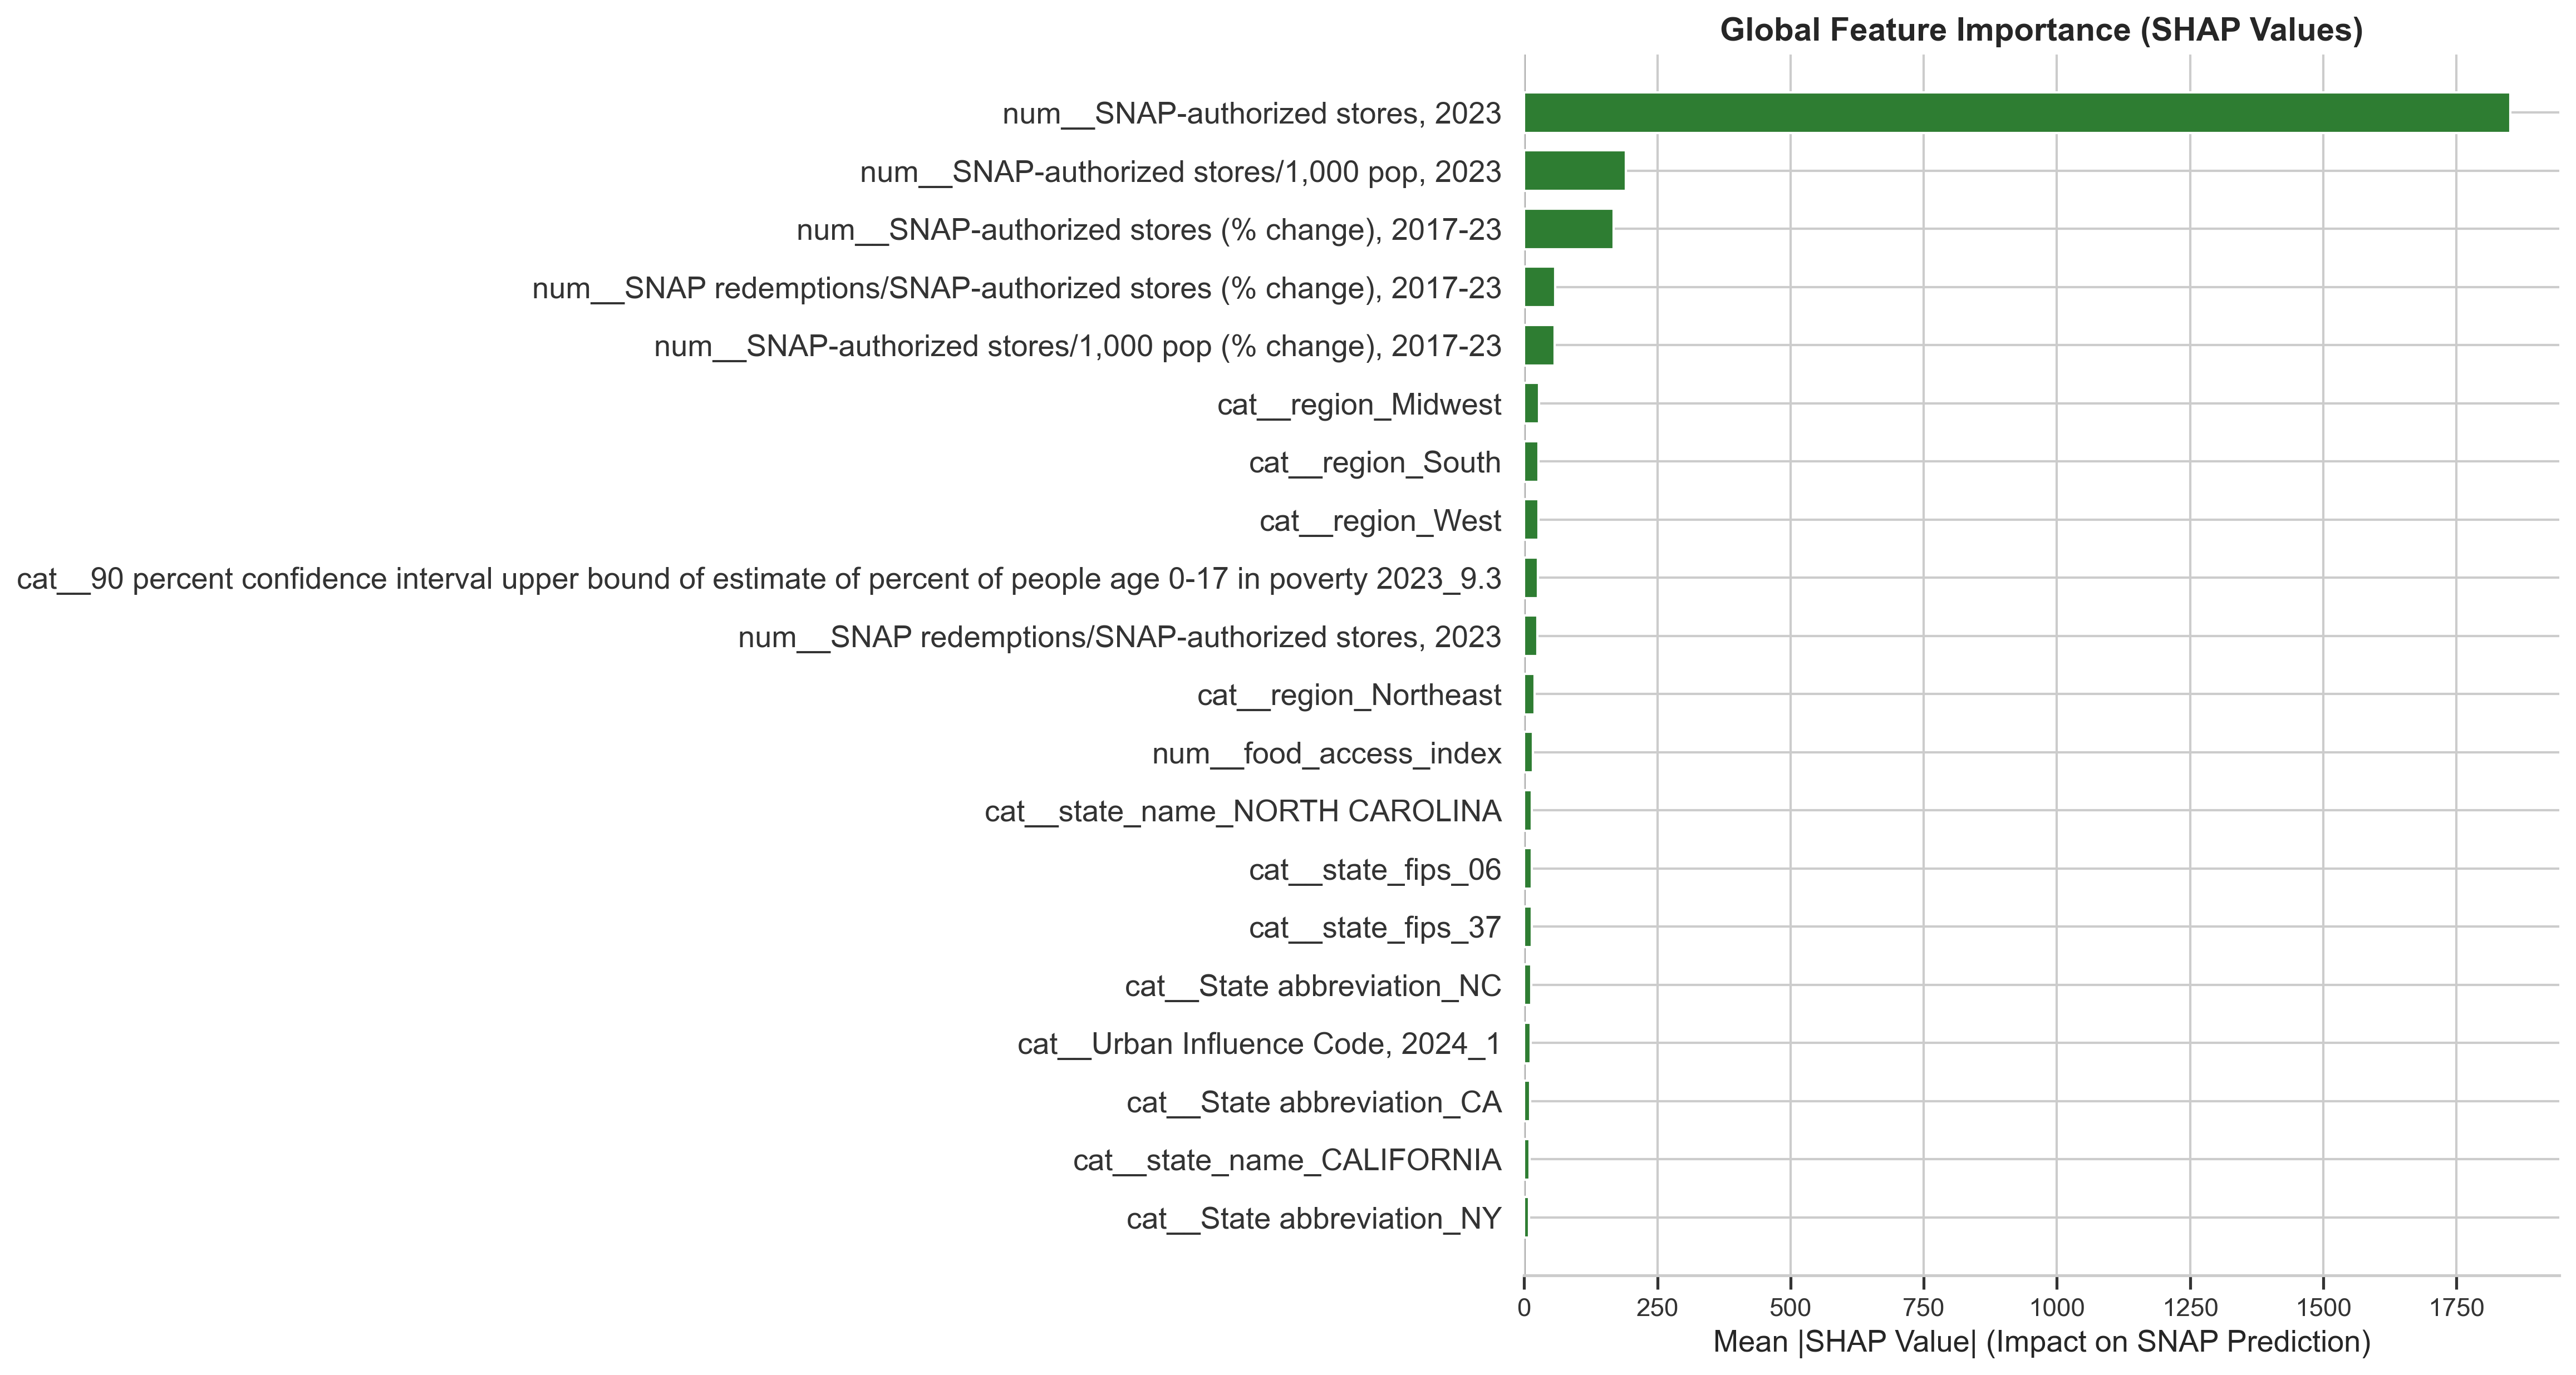

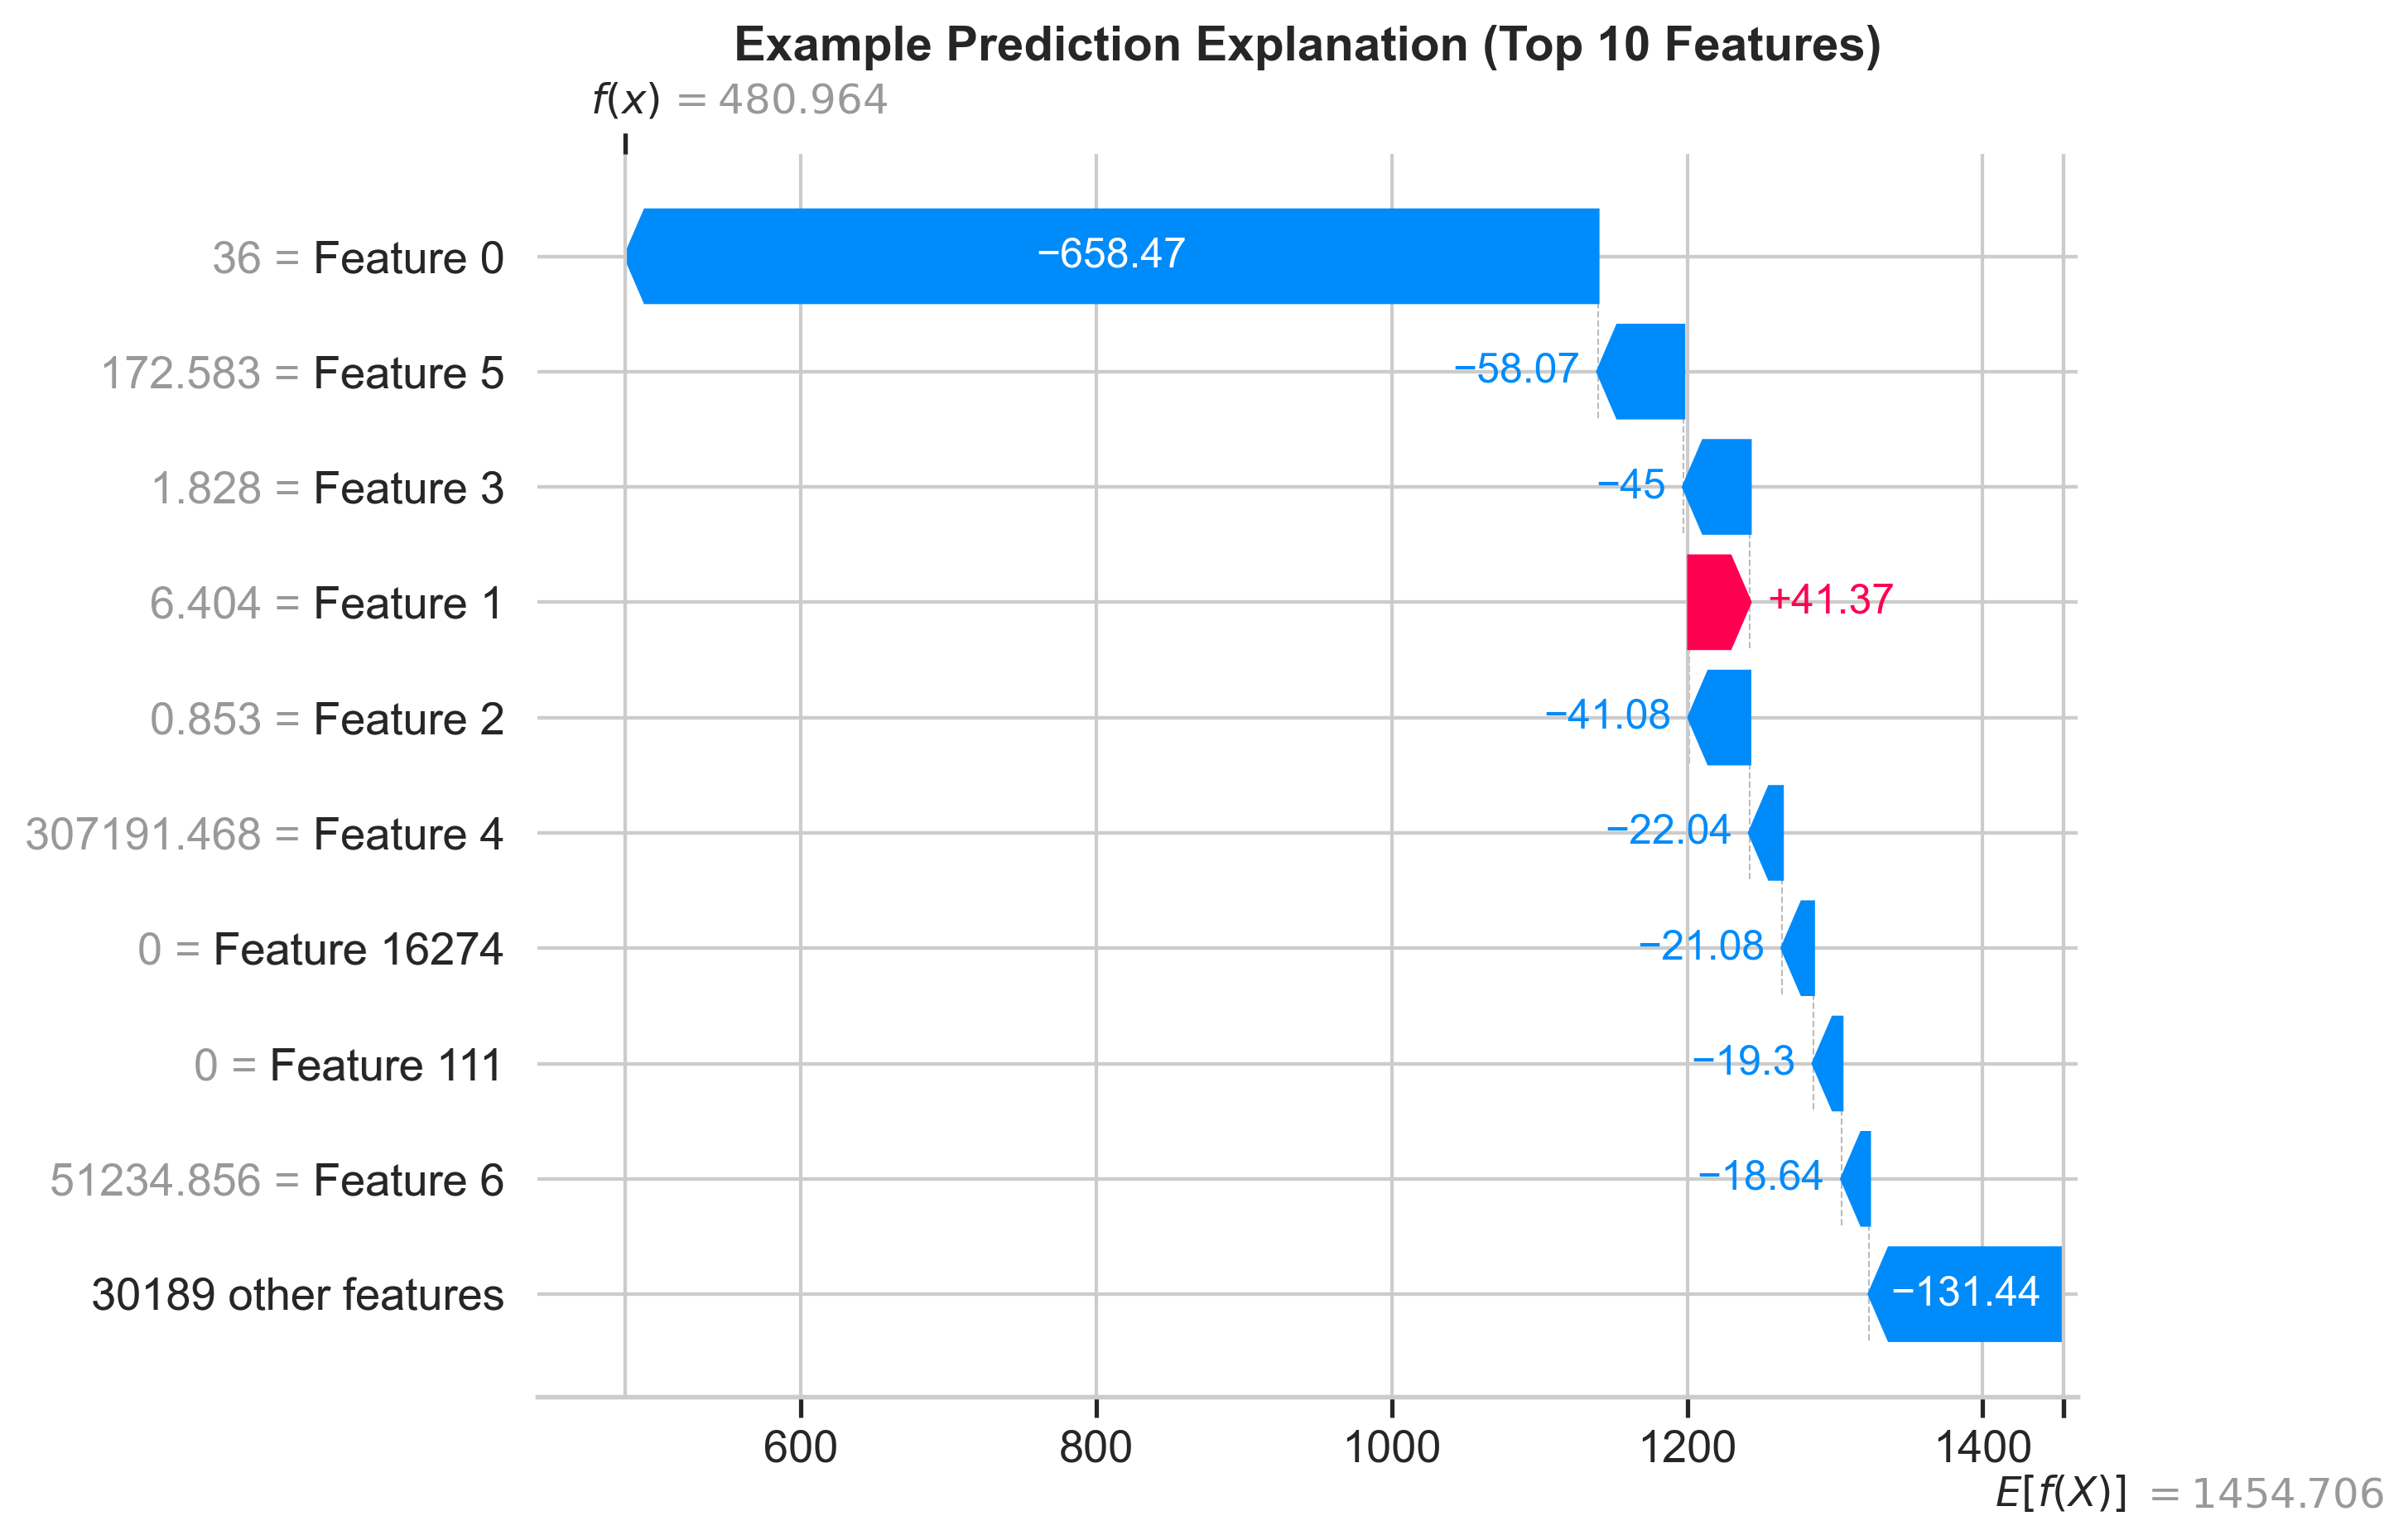

✅ SHAP plots saved to 'figures/'


In [17]:
################################################
# SHAP Explanations (SHapley Additive exPlanations)
################################################

# Visualization - Impact of features on prediction using SHAP

sns.set_theme(style="whitegrid")
main_color = "#2E7D32"   # deep green

# Gets copy of the model and transforms the test data to pull numeric features 
regressor = model.named_steps['regressor']
X_test_t = model.named_steps['preprocessor'].transform(X_test)
if hasattr(X_test_t, "toarray"): X_test_t = X_test_t.toarray()
X_test_t = X_test_t.astype(float)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Explains feature influence on predictions
explainer = shap.Explainer(regressor, X_test_t)
shap_values = explainer(X_test_t)

# Plots features in order of importance to predictions 
plt.figure(figsize=(10,6), dpi=300)
shap.summary_plot(shap_values, X_test_t, feature_names=feature_names,
                  plot_type="bar", color=main_color, show=False)
plt.title("Global Feature Importance (SHAP Values)", fontsize=14, weight="bold")
plt.xlabel("Mean |SHAP Value| (Impact on SNAP Prediction)")
# plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/shap_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

# Plots waterfall chart showing how each feature influenced the prediction of one example
plt.figure(figsize=(10,6), dpi=300)
shap.plots.waterfall(shap_values[0], max_display=10, show=False)
plt.title("Example Prediction Explanation (Top 10 Features)", fontsize=14, weight="bold")
# plt.tight_layout()
plt.savefig("figures/shap_waterfall_example.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ SHAP plots saved to 'figures/'")

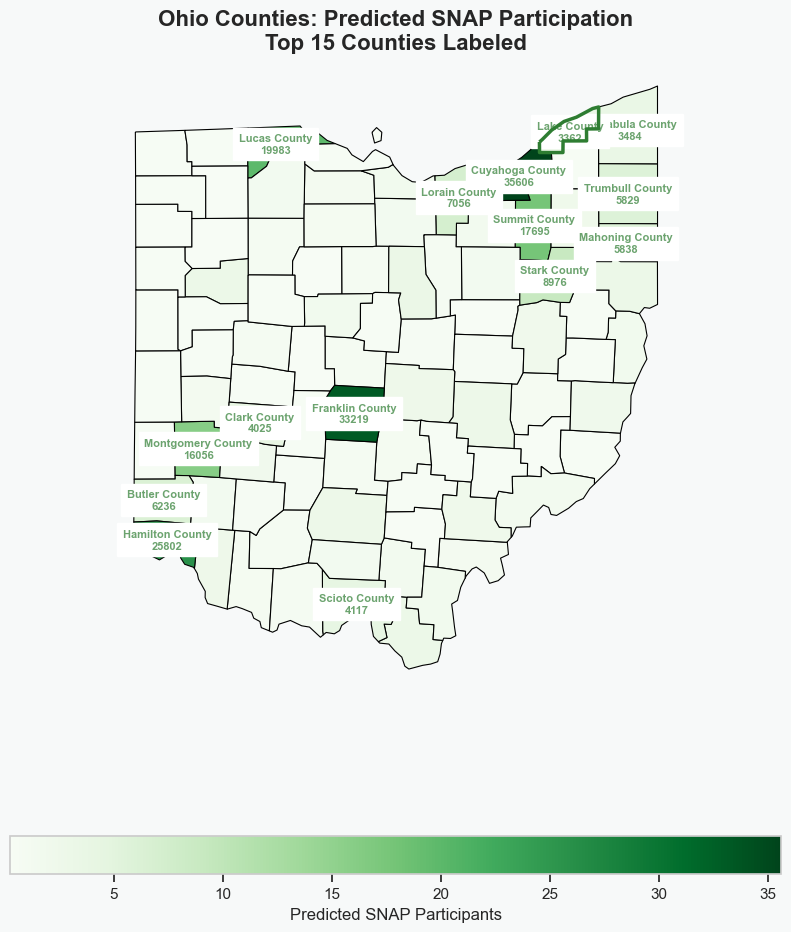

✅ Ohio Top 15 map saved to figures/top_15_ohio_counties_predicted_SNAP.png


In [18]:
# Visualization - Top 15 Ohio counties by predicted SNAP participation

main_color = "#2E7D32"  # deep green
bg_color = "#F7F9F9"    # light background

# Sets top 15 counties
top15_ohio = ohio_gdf.nlargest(15, "Predicted_SNAP_PA")

# Plots map of Ohio with counties by predicted SNAP participation and highlights Lake County as a rising need
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ohio_gdf.plot(
    column='Predicted_SNAP_PA',
    cmap='Greens',
    legend=True,
    edgecolor='black',
    linewidth=0.8,
    ax=ax,
    legend_kwds={
        'label': "Predicted SNAP Participants",
        'orientation': "horizontal",
        'shrink': 0.8
    }
)

# Formats legend labels in thousands
cbar = ax.get_figure().axes[-1]  # colorbar axis
cbar.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1000:.0f}")
)

# Shows county name and predicted SNAP particpation for top 15 counties
for idx, row in top15_ohio.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax.text(
        x, y,
        f"{row['county_name']}\n{row['Predicted_SNAP_PA']:.0f}",
        ha='center',
        va='center',
        fontsize=8,
        fontweight='bold',
        color=main_color,  # deep green
        backgroundcolor='white',
        alpha=0.7
    )

# Highlights Lake County
lake = ohio_gdf[ohio_gdf['county_name'].str.strip().str.lower() == "lake county"]
if not lake.empty:
    lake.boundary.plot(ax=ax, color=main_color, linewidth=2.5, zorder=10)
else:
    print("⚠️ Lake County not found in ohio_gdf")

ax.set_title(
    "Ohio Counties: Predicted SNAP Participation\nTop 15 Counties Labeled",
    fontsize=16,
    weight='bold'
)
ax.axis('off')

fig.patch.set_facecolor(bg_color)
plt.tight_layout()

# Saves and displays chart
os.makedirs("figures", exist_ok=True)
path = "figures/top_15_ohio_counties_predicted_SNAP.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Ohio Top 15 map saved to {path}")